In [1]:
import glob
import csv
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import torch
from torchvision import transforms, utils
from torch.nn.functional import avg_pool2d, interpolate
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from TrainCNN import CNN, Encoder
import os
import seaborn as sns

Köppen climate classification https://en.wikipedia.org/wiki/K%C3%B6ppen_climate_classification

In [2]:
# climates = ['Bsh', 'Bsk', 'Bwh', 'Bwk', 'Cfa', 'Csa', 'Csb', 'Cwa', 'Dfa', 'Dfb', 'Dfc', 'Dsb', 'Dwb', 'Dwc', 'ET']
# models = ['CNN', 'ResNet', 'DenseNet', 'CapsNet', 'ConvCapsNet']

# results = {}
# for climate in climates:
#     results[climate] = {}
#     for model in models:
#         results[climate][model] = []


# climates_dict = {
#   'Bsh': "Arid, Steppe, Hot Climate",
#   'Bsk': "Arid, Steppe, Cold Climate",
#   'Bwh': "Arid, Desert, Hot Climate",
#   'Bwk': "Arid, Desert, Cold Climate",
#   'Cfa': "Temperate, No Dry Season, Hot Summer Climate",
#   'Csa': "Temperate, Dry Summer, Hot Summer Climate",
#   'Csb': "Temperate, Dry Summer, Warm Summer Climate",
#   'Cwa': "Temperate, Dry Winter, Hot Summer Climate",
#   'Dfa': "Continental, No Dry Season, Hot Summer Climate",
#   'Dfb': "Continental, No Dry Season, Warm Summer Climate",
#   'Dfc': "Continental, No Dry Season, Cold Summer Climate",
#   'Dsb': "Continental, Dry Summer, Warm Summer Climate",
#   'Dwb': "Continental, Dry Winter, Warm Summer Climate",
#   'Dwc': "Continental, Dry Winter, Cold Summer Climate",
#   'ET': "Polar, Tundra"
# }

# results_files = glob.glob("results/*/*_Accuracy.txt")

# for results_file in results_files:
#     my_file = open(results_file, "r")
#     results_data = my_file.read()
#     results_model, results_climate = results_file.split("\\")[-1].replace('_Accuracy.txt', '').split("_")
#     results[results_climate][results_model] = results[results_climate][results_model] + [float(i) for i in results_data.split()]
#     my_file.close()
    
# for climate in results.keys():
#     for model, data in results[climate].items():
#         if (len(data) == 0):
#             print(climate)
#             print(model)
# #         results[climate][model] = sum(data) / len(data)

# SSEBOP VS ET

In [11]:
clim_list = ['Bsh','Bsk','Bwh','Bwk','Cfa','Csa','Csb','Cwa','Dfa','Dfb','Dfc','Dsb','Dwb','Dwc','ET']

In [12]:
class EvapoDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, split=False, train_or_test = True, train=0.8, climate=None):
        
        self.file_names_orig = glob.glob("Joined_Data_16x16_Cloudy/*.npy")
        self.vegs = ['BSV', 'CRO', 'CSH', 'DBF', 'ENF', 'GRA', 'MF', 'OSH', 'SAV', 'WAT', 'WET', 'WSA']
        self.clim = ['', 'Bsh', 'Bsk', 'Bwh', 'Bwk', 'Cfa', 'Csa', 'Csb', 'Cwa', 'Dfa', 'Dfb', 'Dfc', 'Dsb', 'Dwb', 'Dwc', 'ET']
        
        
        self.file_names = []
#         for i in self.file_names_orig:
#             if not (('US-A03' in i) or ('US-A10' in i) or ('US-KS4' in i) or ('US-Myb' in i) or ('US-NGB' in i) or ('US-Sne' in i) or 
#             ('US-StJ' in i) or ('US-Tw1' in i) or ('US-Tw3' in i) or ('US-Tw4' in i) or ('US-UMB' in i) or ('US-UMd' in i) or 
#             ('US-xBA' in i) or ('US-xDJ' in i) or ('US-xSE' in i)):
#                 self.file_names.append(i)
                
        for i in self.file_names_orig:
            if (climate is not None):
                if (climate in i.split("_")[-6]):
                    self.file_names.append(i)
            else:
                self.file_names.append(i)
        
        print("Dataset Length " + str(len(self.file_names)))
        
        
        if split:
            random.Random(18).shuffle(self.file_names)
            self.length = len(self.file_names)
            indx = round(self.length * train)
            if train_or_test:
                self.file_names = self.file_names[:indx]
            else:
                self.file_names = self.file_names[indx:]
                
        self.transform = transforms.Compose([
            transforms.Normalize(mean=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])]) 
        

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return self.file_names[idx]

In [13]:
train_randomseed_clim = {}
test_randomseed_clim = {}

for r in range(10):
    train_randomseed_clim[r] = {}
    test_randomseed_clim[r] = {}
    for r2 in clim_list:
        train_randomseed_clim[r][r2] = []
        test_randomseed_clim[r][r2] = []

for c in range(10):
    for c2 in clim_list:
        dataset = EvapoDataset(climate=c2)

        dataset_size = len(dataset)
        indices = list(range(dataset_size))
        validation_split = 0.2
        shuffle_dataset = True
        random_seed = c
        split = int(np.floor(validation_split * dataset_size))
        if shuffle_dataset :
            np.random.seed(random_seed)
            np.random.shuffle(indices)
        train_indices, test_indices = indices[split:], indices[:split]

        # Creating PT data samplers and loaders:
        train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

        train_loader = torch.utils.data.DataLoader(dataset, sampler=train_sampler)
        test_loader = torch.utils.data.DataLoader(dataset, sampler=test_sampler)
        for trainy in train_loader:
            train_randomseed_clim[c][c2].append(trainy[0].split("\\")[-1].replace(".npy", ""))
        for testy in test_loader:
            test_randomseed_clim[c][c2].append(testy[0].split("\\")[-1].replace(".npy", ""))

Dataset Length 153
Dataset Length 635
Dataset Length 30
Dataset Length 110
Dataset Length 599
Dataset Length 496
Dataset Length 69
Dataset Length 38
Dataset Length 547
Dataset Length 362
Dataset Length 128
Dataset Length 31
Dataset Length 47
Dataset Length 91
Dataset Length 117
Dataset Length 153
Dataset Length 635
Dataset Length 30
Dataset Length 110
Dataset Length 599
Dataset Length 496
Dataset Length 69
Dataset Length 38
Dataset Length 547
Dataset Length 362
Dataset Length 128
Dataset Length 31
Dataset Length 47
Dataset Length 91
Dataset Length 117
Dataset Length 153
Dataset Length 635
Dataset Length 30
Dataset Length 110
Dataset Length 599
Dataset Length 496
Dataset Length 69
Dataset Length 38
Dataset Length 547
Dataset Length 362
Dataset Length 128
Dataset Length 31
Dataset Length 47
Dataset Length 91
Dataset Length 117
Dataset Length 153
Dataset Length 635
Dataset Length 30
Dataset Length 110
Dataset Length 599
Dataset Length 496
Dataset Length 69
Dataset Length 38
Dataset Length

In [6]:
# ssebop = glob.glob("Cloud_Removal/SSEBop_Results/*")

In [7]:
# temp = []
# for file in ssebop:
#     image = np.load(file)
#     if (np.isnan(np.average(image[0, -1]))):
#         np.save(file.replace("Cloud_Removal/SSEBop_Results", "NAN_Dataset"), image)

In [8]:
# veg_dict = {
#     "BSV": "Barren Sparse Vegetation",
#     "CRO": "Croplands",
#     "CSH": "Closed Shrublands",
#     "CVM": "Cropland/Natural Vegetation Mosaics",
#     "DBF": "Deciduous Broadleaf Forests",
#     "DNF": "Deciduous Needleleaf Forests",
#     "EBF": "Evergreen Broadleaf Forests",
#     "ENF": "Evergreen Needleleaf Forest",
#     "GRA": "Grasslands",
#     "MF": "Mixed Forests",
#     "OSH": "Open Shrublands",
#     "SAV": "Savannas",
#     "SNO": "Snow and Ice",
#     "URB": "Urban and Built-Up Lands",
#     "WAT": "Water Bodies",
#     "WET": "Permanent Wetlands",
#     "WSA": "Woody Savannas",
# }

In [9]:
ssebop_values = []
eddy_values = []
error = []
day = []
month = []
month_encoded = []
year = []
clim = []
clim_encoded = []
veg = []
veg_encoded = []
lat = []
lon = []
elev = []
geohash = []
site_id = []
train_cnn = []
test_cnn = []
train_cnn_error = []
test_cnn_error = []

train_caps = []
test_caps = []
train_caps_error = []
test_caps_error = []

train_convcaps = []
test_convcaps = []
train_convcaps_error = []
test_convcaps_error = []

month_dict = {
    "01":"January",
    "02":"February",
    "03":"March",
    "04":"April",
    "05":"May",
    "06":"June",
    "07":"July",
    "08":"August",
    "09":"September",
    "10":"October",
    "11":"November",
    "12":"December"
}

clim_dict = {
  'Bsh': "Arid, Steppe, Hot Climate",
  'Bsk': "Arid, Steppe, Cold Climate",
  'Bwh': "Arid, Desert, Hot Climate",
  'Bwk': "Arid, Desert, Cold Climate",
  'Cfa': "Temperate, No Dry Season, Hot Summer Climate",
  'Csa': "Temperate, Dry Summer, Hot Summer Climate",
  'Csb': "Temperate, Dry Summer, Warm Summer Climate",
  'Cwa': "Temperate, Dry Winter, Hot Summer Climate",
  'Dfa': "Continental, No Dry Season, Hot Summer Climate",
  'Dfb': "Continental, No Dry Season, Warm Summer Climate",
  'Dfc': "Continental, No Dry Season, Cold Summer Climate",
  'Dsb': "Continental, Dry Summer, Warm Summer Climate",
  'Dwb': "Continental, Dry Winter, Warm Summer Climate",
  'Dwc': "Continental, Dry Winter, Cold Summer Climate",
  'ET': "Polar, Tundra",
  '': "Other",
    
}

veg_dict = {
    "BSV": "Barren Sparse Vegetation",
    "CRO": "Croplands",
    "CSH": "Closed Shrublands",
    "CVM": "Cropland/Natural Vegetation Mosaics",
    "DBF": "Deciduous Broadleaf Forests",
    "DNF": "Deciduous Needleleaf Forests",
    "EBF": "Evergreen Broadleaf Forests",
    "ENF": "Evergreen Needleleaf Forest",
    "GRA": "Grasslands",
    "MF": "Mixed Forests",
    "OSH": "Open Shrublands",
    "SAV": "Savannas",
    "SNO": "Snow and Ice",
    "URB": "Urban and Built-Up Lands",
    "WAT": "Water Bodies",
    "WET": "Permanent Wetlands",
    "WSA": "Woody Savannas",
}

vegs_list = ['BSV', 'CRO', 'CSH', 'DBF', 'ENF', 'GRA', 'MF', 'OSH', 'SAV', 'WAT', 'WET', 'WSA']

ssebop = glob.glob("Cloud_Removal/SSEBop_Results/*")
for file in ssebop:
    image = np.load(file)
    if (np.isnan(np.average(image[0, -1]))):
        continue
#     print(file.replace(".npy", "").split("_"))
    
    ssebop_values.append(np.average(image[0, -1]))
    error.append(abs(float(file.replace(".npy", "").split("_")[-1]) - np.average(image[0, -1])))
    eddy_values.append(float(file.replace(".npy", "").split("_")[-1]))
    day.append(int(file.replace(".npy", "").split("_")[-2]))
    month.append(int(file.replace(".npy", "").split("_")[-3]))
    month_encoded.append(month_dict[file.replace(".npy", "").split("_")[-3]])
    year.append(int(file.replace(".npy", "").split("_")[-4]))
    clim.append(file.replace(".npy", "").split("_")[-6])
    clim_encoded.append(clim_dict[file.replace(".npy", "").split("_")[-6]])
    veg.append(file.replace(".npy", "").split("_")[-7])
    veg_encoded.append(veg_dict[file.replace(".npy", "").split("_")[-7]])
    lat.append(float(file.replace(".npy", "").split("_")[-10]))
    lon.append(float(file.replace(".npy", "").split("_")[-9]))
    geohash.append(file.replace(".npy", "").split("_")[-5])
    site_id.append(file.replace(".npy", "").split("_")[-11].split("\\")[-1])
    
    file_names_orig = glob.glob("Joined_Data_16x16_Cloudy/*.npy")
    
    cnn_models = glob.glob("checkpoints_CNN/*" + file.replace(".npy", "").split("_")[-6] + '*')
    transform = transforms.Compose([
            transforms.Normalize(mean=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])]) 
    
    cnn_train_list = []
    cnn_test_list = []
    for i in cnn_models:
        model = torch.load(i, map_location=torch.device('cpu'))
        model.eval()
        img = transform(torch.from_numpy(image.astype(float)[0])[:11])
        img = interpolate(img.reshape((1, img.size(0), img.size(1), img.size(2))) , size=32)
        
        date_time_obj = datetime.strptime(file.replace(".npy", "").split("_")[-4] + '_' + file.replace(".npy", "").split("_")[-3] + '_' + file.replace(".npy", "").split("_")[-2], '%Y_%m_%d')
        day_of_year = date_time_obj.timetuple().tm_yday
        day_sin = torch.tensor([np.sin(2 * np.pi * day_of_year/364.0)])
        day_cos = torch.tensor([np.cos(2 * np.pi * day_of_year/364.0)])
        
        veg2 = torch.nn.functional.one_hot(torch.tensor(vegs_list.index(file.replace(".npy", "").split("_")[-7])), num_classes=12)
        
        lat2 = float(file.replace(".npy", "").split("_")[-10])
        lon2 = float(file.replace(".npy", "").split("_")[-9])
        x_coord = torch.tensor([np.cos(lat2) * np.cos(lon2)])
        y_coord = torch.tensor([np.cos(lat2) * np.sin(lon2)])
        z_coord = torch.tensor([np.sin(lat2)])
       
        elev2 = torch.tensor([float(file.replace(".npy", "").split("_")[-8])/20310.0]) # Tallest Point in US is 20310
        
        img = img.to(dtype=torch.float32)
        veg2 = veg2.to(dtype=torch.float32)
        day_sin = day_sin.to(dtype=torch.float32)
        day_cos = day_cos.to(dtype=torch.float32)
        x_coord = x_coord.to(dtype=torch.float32)
        y_coord = y_coord.to(dtype=torch.float32)
        z_coord = z_coord.to(dtype=torch.float32)
        elev2 = elev2.to(dtype=torch.float32)
        
        cnn_output = model(img, torch.cat((veg2, day_sin, day_cos, x_coord, y_coord, z_coord, elev2), dim=0).reshape(1, -1))
        
        if (file.split("\\")[-1].replace(".npy", "") in train_randomseed_clim[int(i.split('_')[-1].replace('.pt', ''))][i.split('_')[-2]]):
            cnn_train_list.append(cnn_output)
        if (file.split("\\")[-1].replace(".npy", "") in test_randomseed_clim[int(i.split('_')[-1].replace('.pt', ''))][i.split('_')[-2]]):
            cnn_test_list.append(cnn_output)
        
    if (len(cnn_train_list) > 0):
        train_cnn.append(sum(cnn_train_list)/len(cnn_train_list))
        train_cnn_error.append(abs(sum(cnn_train_list)/len(cnn_train_list) - float(file.replace(".npy", "").split("_")[-1])))
    else:
        train_cnn.append(None)
        train_cnn_error.append(None)
        
    if (len(cnn_test_list) > 0):
        test_cnn.append(sum(cnn_test_list)/len(cnn_test_list))
#         test_cnn_error.append(abs(sum(cnn_test_list)/len(cnn_test_list) - float(file.replace(".npy", "").split("_")[-1])))
    else:
        test_cnn.append(None)
#         test_cnn_error.append(None)


    caps_models = glob.glob("checkpoints_CapsNet/*" + file.replace(".npy", "").split("_")[-6] + '*')
    
    caps_train_list = []
    caps_test_list = []
    for i in caps_models:
        model = torch.load(i, map_location=torch.device('cpu'))
        model.eval()
        img = transform(torch.from_numpy(image.astype(float)[0])[:11])
        img = interpolate(img.reshape((1, img.size(0), img.size(1), img.size(2))) , size=32)
        
        date_time_obj = datetime.strptime(file.replace(".npy", "").split("_")[-4] + '_' + file.replace(".npy", "").split("_")[-3] + '_' + file.replace(".npy", "").split("_")[-2], '%Y_%m_%d')
        day_of_year = date_time_obj.timetuple().tm_yday
        day_sin = torch.tensor([np.sin(2 * np.pi * day_of_year/364.0)])
        day_cos = torch.tensor([np.cos(2 * np.pi * day_of_year/364.0)])
        
        veg2 = torch.nn.functional.one_hot(torch.tensor(vegs_list.index(file.replace(".npy", "").split("_")[-7])), num_classes=12)
        
        lat2 = float(file.replace(".npy", "").split("_")[-10])
        lon2 = float(file.replace(".npy", "").split("_")[-9])
        x_coord = torch.tensor([np.cos(lat2) * np.cos(lon2)])
        y_coord = torch.tensor([np.cos(lat2) * np.sin(lon2)])
        z_coord = torch.tensor([np.sin(lat2)])
       
        elev2 = torch.tensor([float(file.replace(".npy", "").split("_")[-8])/20310.0]) # Tallest Point in US is 20310
        
        img = img.to(dtype=torch.float32)
        veg2 = veg2.to(dtype=torch.float32)
        day_sin = day_sin.to(dtype=torch.float32)
        day_cos = day_cos.to(dtype=torch.float32)
        x_coord = x_coord.to(dtype=torch.float32)
        y_coord = y_coord.to(dtype=torch.float32)
        z_coord = z_coord.to(dtype=torch.float32)
        elev2 = elev2.to(dtype=torch.float32)
        
        caps_output = model(img, torch.cat((veg2, day_sin, day_cos, x_coord, y_coord, z_coord, elev2), dim=0).reshape(1, -1))
        
        if (file.split("\\")[-1].replace(".npy", "") in train_randomseed_clim[int(i.split('_')[-1].replace('.pt', ''))][i.split('_')[-2]]):
            caps_train_list.append(caps_output)
        if (file.split("\\")[-1].replace(".npy", "") in test_randomseed_clim[int(i.split('_')[-1].replace('.pt', ''))][i.split('_')[-2]]):
            caps_test_list.append(caps_output)
        
    if (len(caps_train_list) > 0):
        train_caps.append(sum(caps_train_list)/len(caps_train_list))
        train_caps_error.append(abs(sum(caps_train_list)/len(caps_train_list) - float(file.replace(".npy", "").split("_")[-1])))
    else:
        train_caps.append(None)
        train_caps_error.append(None)
        
    if (len(caps_test_list) > 0):
        test_caps.append(sum(caps_test_list)/len(caps_test_list))
    else:
        test_caps.append(None)
        
    convcaps_models = glob.glob("checkpoints_ConvCaps/*" + file.replace(".npy", "").split("_")[-6] + '*')
    
    convcaps_train_list = []
    convcaps_test_list = []
    for i in convcaps_models:
        model = torch.load(i, map_location=torch.device('cpu'))
        model.eval()
        img = transform(torch.from_numpy(image.astype(float)[0])[:11])
        img = interpolate(img.reshape((1, img.size(0), img.size(1), img.size(2))) , size=32)
        
        date_time_obj = datetime.strptime(file.replace(".npy", "").split("_")[-4] + '_' + file.replace(".npy", "").split("_")[-3] + '_' + file.replace(".npy", "").split("_")[-2], '%Y_%m_%d')
        day_of_year = date_time_obj.timetuple().tm_yday
        day_sin = torch.tensor([np.sin(2 * np.pi * day_of_year/364.0)])
        day_cos = torch.tensor([np.cos(2 * np.pi * day_of_year/364.0)])
        
        veg2 = torch.nn.functional.one_hot(torch.tensor(vegs_list.index(file.replace(".npy", "").split("_")[-7])), num_classes=12)
        
        lat2 = float(file.replace(".npy", "").split("_")[-10])
        lon2 = float(file.replace(".npy", "").split("_")[-9])
        x_coord = torch.tensor([np.cos(lat2) * np.cos(lon2)])
        y_coord = torch.tensor([np.cos(lat2) * np.sin(lon2)])
        z_coord = torch.tensor([np.sin(lat2)])
       
        elev2 = torch.tensor([float(file.replace(".npy", "").split("_")[-8])/20310.0]) # Tallest Point in US is 20310
        
        img = img.to(dtype=torch.float32)
        veg2 = veg2.to(dtype=torch.float32)
        day_sin = day_sin.to(dtype=torch.float32)
        day_cos = day_cos.to(dtype=torch.float32)
        x_coord = x_coord.to(dtype=torch.float32)
        y_coord = y_coord.to(dtype=torch.float32)
        z_coord = z_coord.to(dtype=torch.float32)
        elev2 = elev2.to(dtype=torch.float32)
        
        convcaps_output = model(img, torch.cat((veg2, day_sin, day_cos, x_coord, y_coord, z_coord, elev2), dim=0).reshape(1, -1))
        
        if (file.split("\\")[-1].replace(".npy", "") in train_randomseed_clim[int(i.split('_')[-1].replace('.pt', ''))][i.split('_')[-2]]):
            convcaps_train_list.append(convcaps_output)
        if (file.split("\\")[-1].replace(".npy", "") in test_randomseed_clim[int(i.split('_')[-1].replace('.pt', ''))][i.split('_')[-2]]):
            convcaps_test_list.append(convcaps_output)
        
    if (len(convcaps_train_list) > 0):
        train_convcaps.append(sum(convcaps_train_list)/len(convcaps_train_list))
        train_convcaps_error.append(abs(sum(convcaps_train_list)/len(convcaps_train_list) - float(file.replace(".npy", "").split("_")[-1])))
    else:
        train_convcaps.append(None)
        train_convcaps_error.append(None)
        
    if (len(convcaps_test_list) > 0):
        test_convcaps.append(sum(convcaps_test_list)/len(convcaps_test_list))
    else:
        test_convcaps.append(None)
    print(len(test_convcaps))
    
d = {'Latitiude': lat, 'Longitude': lon, 'Site_ID': site_id, 'Error': error, 'SSEBop': ssebop_values, 'Eddy': eddy_values, 'Mon': month, 'Month': month_encoded, 'Year': year, "Day": day,
         "Clim": clim, "Climate": clim_encoded, "Veg": veg, "Vegetation": veg_encoded, "Geohash": geohash, "CNN_Train_Output": train_cnn, 
         "CNN_Test_Output": test_cnn, "CNN_Train_Error": train_cnn_error, "CNN_Test_Error": test_cnn_error,
         "Caps_Train_Output": train_caps, "Caps_Test_Output": test_caps, "Caps_Train_Error": train_caps_error, "Caps_Test_Error": test_caps_error,
         "ConvCaps_Train_Output": train_convcaps, "ConvCaps_Test_Output": test_convcaps, "ConvCaps_Train_Error": train_convcaps_error, "ConvCaps_Test_Error": test_convcaps_error,
        }
    df = pd.DataFrame(data=d)
    df.to_csv("Cloudy" + str(ind) + ".csv")

NameError: name 'train_randomseed_clim' is not defined

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import torch
from torchvision import transforms, utils
from torch.nn.functional import avg_pool2d, interpolate
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from TrainCNN import CNN, Encoder
from TrainCaps import PrimaryCapsules, RoutingCapsules, CapsuleNetwork, CapsNet
from TrainConvCaps import convolutionalCapsule, Encoder, ConvCapsNet
import os
# os.makedirs("NAN_Dataset", exist_ok = True)

clim_list = ['Bsh','Bsk','Bwh','Bwk','Cfa','Csa','Csb','Cwa','Dfa','Dfb','Dfc','Dsb','Dwb','Dwc','ET']

class EvapoDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, split=False, train_or_test = True, train=0.8, climate=None):
        
        self.file_names_orig = glob.glob("Joined_Data_16x16_Cloudy/*.npy")
        self.vegs = ['BSV', 'CRO', 'CSH', 'DBF', 'ENF', 'GRA', 'MF', 'OSH', 'SAV', 'WAT', 'WET', 'WSA']
        self.clim = ['', 'Bsh', 'Bsk', 'Bwh', 'Bwk', 'Cfa', 'Csa', 'Csb', 'Cwa', 'Dfa', 'Dfb', 'Dfc', 'Dsb', 'Dwb', 'Dwc', 'ET']
        
        
        self.file_names = []
#         for i in self.file_names_orig:
#             if not (('US-A03' in i) or ('US-A10' in i) or ('US-KS4' in i) or ('US-Myb' in i) or ('US-NGB' in i) or ('US-Sne' in i) or 
#             ('US-StJ' in i) or ('US-Tw1' in i) or ('US-Tw3' in i) or ('US-Tw4' in i) or ('US-UMB' in i) or ('US-UMd' in i) or 
#             ('US-xBA' in i) or ('US-xDJ' in i) or ('US-xSE' in i)):
#                 self.file_names.append(i)
                
        for i in self.file_names_orig:
            if (climate is not None):
                if (climate in i.split("_")[-6]):
                    self.file_names.append(i)
            else:
                self.file_names.append(i)
        
        print("Dataset Length " + str(len(self.file_names)))
        
        
        if split:
            random.Random(18).shuffle(self.file_names)
            self.length = len(self.file_names)
            indx = round(self.length * train)
            if train_or_test:
                self.file_names = self.file_names[:indx]
            else:
                self.file_names = self.file_names[indx:]
                
        self.transform = transforms.Compose([
            transforms.Normalize(mean=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])]) 
        

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return self.file_names[idx]
    
train_randomseed_clim = {}
test_randomseed_clim = {}

for r in range(10):
    train_randomseed_clim[r] = {}
    test_randomseed_clim[r] = {}
    for r2 in clim_list:
        train_randomseed_clim[r][r2] = []
        test_randomseed_clim[r][r2] = []

for c in range(10):
    for c2 in clim_list:
        dataset = EvapoDataset(climate=c2)

        dataset_size = len(dataset)
        indices = list(range(dataset_size))
        validation_split = 0.2
        shuffle_dataset = True
        random_seed = c
        split = int(np.floor(validation_split * dataset_size))
        if shuffle_dataset :
            np.random.seed(random_seed)
            np.random.shuffle(indices)
        train_indices, test_indices = indices[split:], indices[:split]

        # Creating PT data samplers and loaders:
        train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

        train_loader = torch.utils.data.DataLoader(dataset, sampler=train_sampler)
        test_loader = torch.utils.data.DataLoader(dataset, sampler=test_sampler)
        for trainy in train_loader:
            train_randomseed_clim[c][c2].append(trainy[0].split("/")[-1].replace(".npy", ""))
        for testy in test_loader:
            test_randomseed_clim[c][c2].append(testy[0].split("/")[-1].replace(".npy", ""))
            
ssebop = glob.glob("Cloud_Removal/SSEBop_Results_0.8/*")

veg_dict = {
    "BSV": "Barren Sparse Vegetation",
    "CRO": "Croplands",
    "CSH": "Closed Shrublands",
    "CVM": "Cropland/Natural Vegetation Mosaics",
    "DBF": "Deciduous Broadleaf Forests",
    "DNF": "Deciduous Needleleaf Forests",
    "EBF": "Evergreen Broadleaf Forests",
    "ENF": "Evergreen Needleleaf Forest",
    "GRA": "Grasslands",
    "MF": "Mixed Forests",
    "OSH": "Open Shrublands",
    "SAV": "Savannas",
    "SNO": "Snow and Ice",
    "URB": "Urban and Built-Up Lands",
    "WAT": "Water Bodies",
    "WET": "Permanent Wetlands",
    "WSA": "Woody Savannas",
}

ssebop_values = []
eddy_values = []
error = []
day = []
month = []
month_encoded = []
year = []
clim = []
clim_encoded = []
veg = []
veg_encoded = []
lat = []
lon = []
elev = []
geohash = []
site_id = []
train_cnn = []
test_cnn = []
train_cnn_error = []
test_cnn_error = []


month_dict = {
    "01":"January",
    "02":"February",
    "03":"March",
    "04":"April",
    "05":"May",
    "06":"June",
    "07":"July",
    "08":"August",
    "09":"September",
    "10":"October",
    "11":"November",
    "12":"December"
}

clim_dict = {
  'Bsh': "Arid, Steppe, Hot Climate",
  'Bsk': "Arid, Steppe, Cold Climate",
  'Bwh': "Arid, Desert, Hot Climate",
  'Bwk': "Arid, Desert, Cold Climate",
  'Cfa': "Temperate, No Dry Season, Hot Summer Climate",
  'Csa': "Temperate, Dry Summer, Hot Summer Climate",
  'Csb': "Temperate, Dry Summer, Warm Summer Climate",
  'Cwa': "Temperate, Dry Winter, Hot Summer Climate",
  'Dfa': "Continental, No Dry Season, Hot Summer Climate",
  'Dfb': "Continental, No Dry Season, Warm Summer Climate",
  'Dfc': "Continental, No Dry Season, Cold Summer Climate",
  'Dsb': "Continental, Dry Summer, Warm Summer Climate",
  'Dwb': "Continental, Dry Winter, Warm Summer Climate",
  'Dwc': "Continental, Dry Winter, Cold Summer Climate",
  'ET': "Polar, Tundra",
  '': "Other",
    
}

veg_dict = {
    "BSV": "Barren Sparse Vegetation",
    "CRO": "Croplands",
    "CSH": "Closed Shrublands",
    "CVM": "Cropland/Natural Vegetation Mosaics",
    "DBF": "Deciduous Broadleaf Forests",
    "DNF": "Deciduous Needleleaf Forests",
    "EBF": "Evergreen Broadleaf Forests",
    "ENF": "Evergreen Needleleaf Forest",
    "GRA": "Grasslands",
    "MF": "Mixed Forests",
    "OSH": "Open Shrublands",
    "SAV": "Savannas",
    "SNO": "Snow and Ice",
    "URB": "Urban and Built-Up Lands",
    "WAT": "Water Bodies",
    "WET": "Permanent Wetlands",
    "WSA": "Woody Savannas",
}

vegs_list = ['BSV', 'CRO', 'CSH', 'DBF', 'ENF', 'GRA', 'MF', 'OSH', 'SAV', 'WAT', 'WET', 'WSA']

ssebop_values = []
eddy_values = []
error = []
day = []
month = []
month_encoded = []
year = []
clim = []
clim_encoded = []
veg = []
veg_encoded = []
lat = []
lon = []
elev = []
geohash = []
site_id = []
train_cnn = []
test_cnn = []
train_cnn_error = []
test_cnn_error = []
train_caps = []
test_caps = []
train_caps_error = []
test_caps_error = []
train_convcaps = []
test_convcaps = []
train_convcaps_error = []
test_convcaps_error = []

for file in ssebop:
    image = np.load(file)
#     print(file.replace(".npy", "").split("_"))

    if (np.isnan(np.average(image[0, -1]))):
        continue
#     ssebop_values.append(np.average(image[0, -1]))
#     error.append(abs(float(file.replace(".npy", "").split("_")[-1]) - np.average(image[0, -1])))
#     eddy_values.append(float(file.replace(".npy", "").split("_")[-1]))
#     day.append(int(file.replace(".npy", "").split("_")[-2]))
#     month.append(int(file.replace(".npy", "").split("_")[-3]))
#     month_encoded.append(month_dict[file.replace(".npy", "").split("_")[-3]])
#     year.append(int(file.replace(".npy", "").split("_")[-4]))
    clim.append(file.replace(".npy", "").split("_")[-6])
    clim_encoded.append(clim_dict[file.replace(".npy", "").split("_")[-6]])
    veg.append(file.replace(".npy", "").split("_")[-7])
    veg_encoded.append(veg_dict[file.replace(".npy", "").split("_")[-7]])
#     lat.append(float(file.replace(".npy", "").split("_")[-10]))
#     lon.append(float(file.replace(".npy", "").split("_")[-9]))
#     geohash.append(file.replace(".npy", "").split("_")[-5])
#     site_id.append(file.replace(".npy", "").split("_")[-11].split("/")[-1])
    print(len(veg))

b = {'Clim': clim, 'Climate': clim_encoded, 'Veg': veg, 'Vegation': veg_encoded
    }    


df = pd.DataFrame(data=b)
df.to_csv("Clim_Veg.csv")

Dataset Length 153
Dataset Length 635
Dataset Length 30
Dataset Length 110
Dataset Length 599
Dataset Length 496
Dataset Length 69
Dataset Length 38
Dataset Length 547
Dataset Length 362
Dataset Length 128
Dataset Length 31
Dataset Length 47
Dataset Length 91
Dataset Length 117
Dataset Length 153
Dataset Length 635
Dataset Length 30
Dataset Length 110
Dataset Length 599
Dataset Length 496
Dataset Length 69
Dataset Length 38
Dataset Length 547
Dataset Length 362
Dataset Length 128
Dataset Length 31
Dataset Length 47
Dataset Length 91
Dataset Length 117
Dataset Length 153
Dataset Length 635
Dataset Length 30
Dataset Length 110
Dataset Length 599
Dataset Length 496
Dataset Length 69
Dataset Length 38
Dataset Length 547
Dataset Length 362
Dataset Length 128
Dataset Length 31
Dataset Length 47
Dataset Length 91
Dataset Length 117
Dataset Length 153
Dataset Length 635
Dataset Length 30
Dataset Length 110
Dataset Length 599
Dataset Length 496
Dataset Length 69
Dataset Length 38
Dataset Length

1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517


2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174


In [123]:
df

Unnamed: 0  Latitiude  Longitude     Error    SSEBop      Eddy  \
Site_ID                                                                    
US-A32   1060.560000    36.8193   -97.8198  3.565068  5.938016  2.514190   
US-A74   1129.750000    36.8085   -97.5489  3.174148  5.744386  2.636974   
US-ADR   1110.214286    36.7653  -116.6933  4.087152  4.337590  0.250439   
US-ALQ    986.600000    46.0308   -89.6067  2.331774  4.056839  1.919164   
US-ARM   1216.115385    36.6058   -97.4888  3.083575  5.220655  2.239620   
...              ...        ...        ...       ...       ...       ...   
US-xST    535.000000    45.5089   -89.5864  3.075675  6.822629  3.746955   
US-xTA    536.000000    32.9505   -87.3933  4.590029  5.899936  1.309907   
US-xTR   1252.909091    45.4937   -89.5857  3.756168  4.828357  1.072189   
US-xUK    545.000000    39.0404   -95.1921  0.969166  3.039821  2.818379   
US-xWD   1275.000000    47.1282   -99.2414  2.846784  3.434989  0.588205   

               Mon         Year        Day  CNN_Train_Output  ...  \
Site_ID                                                       ...   
US-A32    6.440000  2016.040000  17.360000          2.744435  ...   
US-A74    5.350000  2016.450000  15.900000          2.664987  ...   
US-ADR    5.619048  2016.142857  17.333333          0.265144  ...   
US-ALQ    4.600000  2016.100000  16.100000          1.989860  ...   
US-ARM    6.153846  2016.173077  16.846154          2.201692  ...   
...            ...          ...        ...               ...  ...   
US-xST    9.000000  2017.000000  12.000000          2.271380  ...   
US-xTA   10.000000  2017.000000   2.000000          1.515054  ...   
US-xTR    9.545455  2017.000000  12.090909          1.572833  ...   
US-xUK    9.333333  2017.000000  21.666667          2.132107  ...   
US-xWD   10.166667  2017.000000  19.166667          0.460646  ...   

         CNN_Test_Error  Caps_Train_Output  Caps_Test_Output  \
Site_ID                                                        
US-A32         1.142968           2.742453          3.006455   
US-A74         0.948234           2.618633          2.602987   
US-ADR         0.197730           0.261148          0.265029   
US-ALQ         0.506986           2.103682          2.078179   
US-ARM         0.996711           2.347460          2.378238   
...                 ...                ...               ...   
US-xST         1.593579           2.242365          1.965894   
US-xTA              NaN           2.179798               NaN   
US-xTR         0.890661           1.647352          1.832734   
US-xUK         0.788929           2.041195          1.937624   
US-xWD         0.625572           0.549540          0.216694   

         Caps_Train_Error  Caps_Test_Error  ConvCaps_Train_Output  \
Site_ID                                                             
US-A32           1.028775         1.264034               2.512336   
US-A74           0.846829         0.929618               2.500080   
US-ADR           0.133132         0.164615               0.129743   
US-ALQ           0.426634         0.481396               2.141243   
US-ARM           1.133476         1.101044               1.958287   
...                   ...              ...                    ...   
US-xST           1.504589         1.781061               2.080693   
US-xTA           0.869890              NaN               1.973105   
US-xTR           0.799834         0.897272               1.769481   
US-xUK           0.988956         0.989869               2.129888   
US-xWD           0.470208         0.681347               0.533081   

         ConvCaps_Test_Output  ConvCaps_Train_Error  ConvCaps_Test_Error  \
Site_ID                                                                    
US-A32               2.847957              0.964138             1.067240   
US-A74               2.378128              0.839327             0.782825   
US-ADR               0.194468              0.230296             0.209724   
US-ALQ      

In [4]:
import os
import glob
import pandas as pd
extension = 'csv'
all_filenames = ["Cloudy0.csv", "Cloudy1.csv", "Cloudy2.csv", "Cloudy3.csv", "Cloudy4.csv", "Cloudy5.csv", 
                 "Cloudy6.csv", "Cloudy7.csv", "Cloudy8.csv", "Cloudy9.csv"]
all_filenames = glob.glob("Cloudy*.csv")
#combine all files in the list
all_filenames

['Cloudy.csv',
 'Cloudy0.csv',
 'Cloudy1.csv',
 'Cloudy2.csv',
 'Cloudy3.csv',
 'Cloudy4.csv',
 'Cloudy9.csv',
 'Cloudy10.csv',
 'Cloudy11.csv',
 'Cloudy12.csv',
 'Cloudy13.csv',
 'Cloudy14.csv',
 'Cloudy15.csv',
 'Cloudy16.csv',
 'Cloudy17.csv',
 'Cloudy18.csv']

In [5]:
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "Cloudy0_9.csv", index=False, encoding='utf-8-sig')

In [ ]:
# d = {'Latitiude': lat, 'Longitude': lon, 'Site_ID': site_id, 'Error': error, 'SSEBop': ssebop_values, 'Eddy': eddy_values, 'Mon': month, 'Month': month_encoded, 'Year': year, 
#      "Clim": clim, "Climate": clim_encoded, "Veg": veg, "Vegetation": veg_encoded, "Geohash": geohash
#     }
# df = pd.DataFrame(data=d)
# df.to_csv("Cloudy.csv")
# df

In [ ]:
# site_id_temp = []
# error_temp = []
# lat_temp = []
# lon_temp = []
# for uniq in np.unique(df["Site_ID"]):
#     temp = df[["Site_ID", "Error", 'Latitiude', 'Longitude']]
#     temp2 = temp[temp.Site_ID == uniq]
#     site_id_temp.append(uniq)
#     error_temp.append(np.average(temp2['Error']))
#     lat_temp.append(np.average(temp2['Latitiude']))
#     lon_temp.append(np.average(temp2['Longitude']))

In [ ]:
# cnn_output = glob.glob("results/CNN*")

In [ ]:
# for output in cnn_output:
#     file1 = open(output, 'r')
#     Lines = file1.readlines()
#     # Strips the newline character
#     for line in Lines:
#         print(float(line))

In [ ]:
# b = {'Site_ID': site_id_temp, 'Latitiude': lat_temp, 'Longitude': lon_temp, 'Error': error_temp, 
#     }
# bf = pd.DataFrame(data=b)
# bf.to_csv("Cloudy.csv")
# # df
# bf

In [6]:
import pandas as pd
import numpy as np

In [167]:
cf = pd.read_csv('Cloudy0_9.csv')  

In [168]:
bf = pd.read_csv('Clim_Veg.csv')  

In [169]:
df = cf.join(bf, lsuffix='CL', rsuffix='')

In [8]:
len(np.unique(df["Vegetation"]))

12

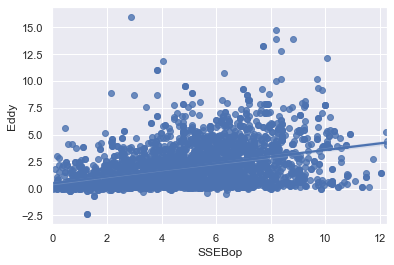

In [9]:
sns.set_theme(color_codes=True)
ax = sns.regplot(x="SSEBop", y="Eddy", data=df)

In [185]:
str(np.corrcoef(df["SSEBop"], df["Eddy"])[0, 1])

'0.3787242531951761'

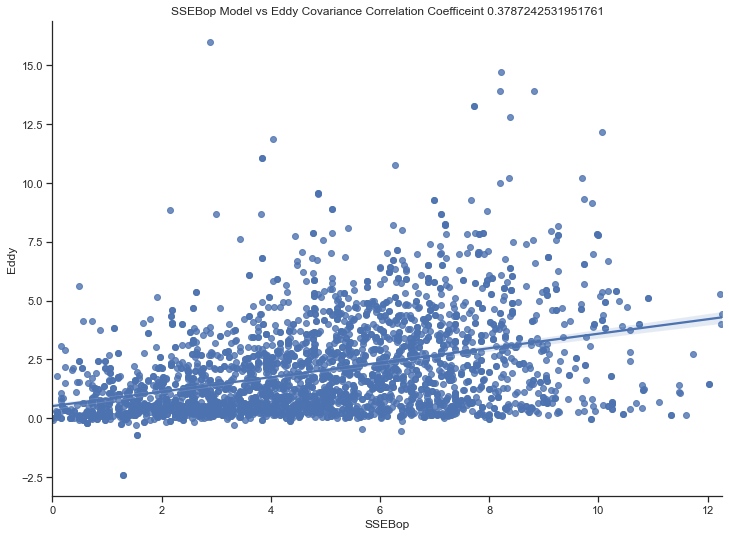

In [150]:
sns.set_theme(color_codes=True)

# some artificial data
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(12, 8.75)
ax = sns.regplot(x="SSEBop", y="Eddy", data=df, ax=ax).set_title("SSEBop Model vs Eddy Covariance Correlation Coefficeint " + str(np.corrcoef(df["SSEBop"], df["Eddy"])[0, 1]))
sns.despine()

Text(0.5, 1.0, 'Absolute Error of SSEBop vs Eddy Covariance')

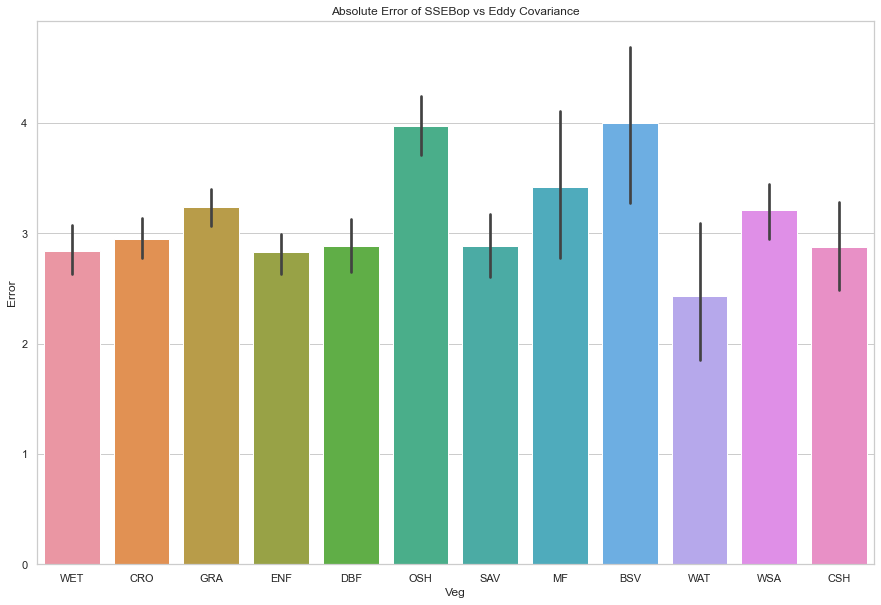

In [188]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.barplot(x="Veg", y="Error", data=df, ax=ax)
ax.set_title('Absolute Error of SSEBop vs Eddy Covariance')

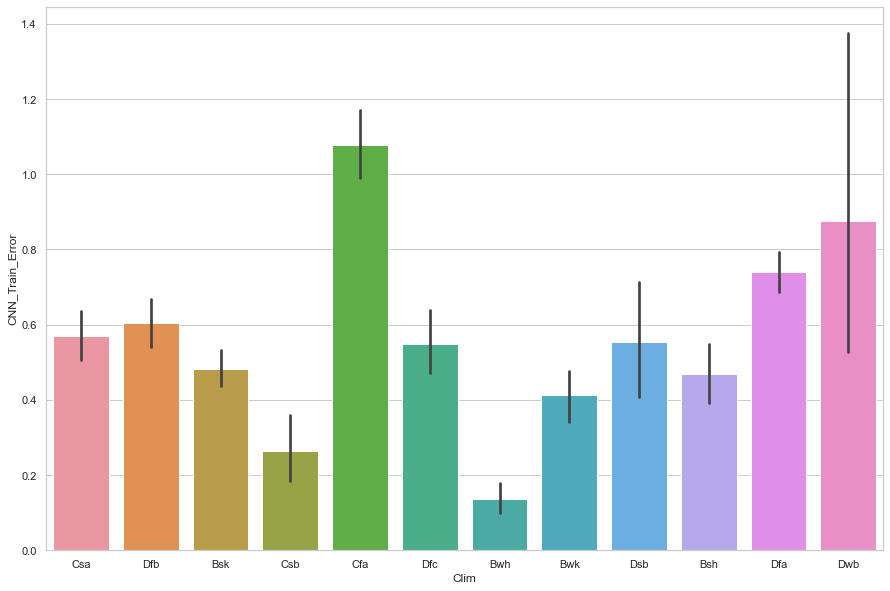

In [12]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.barplot(x="Clim", y="CNN_Train_Error", data=df, ax=ax)

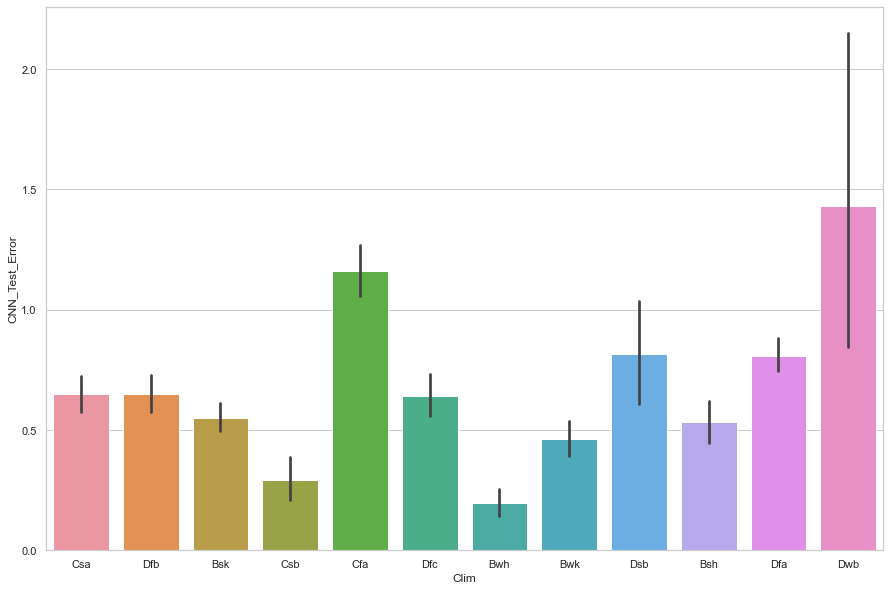

In [13]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.barplot(x="Clim", y="CNN_Test_Error", data=df, ax=ax)

In [14]:
float(np.average(df[df.Clim == "Bsh"]["CNN_Test_Error"][~np.isnan(df[df.Clim == "Bsh"]["CNN_Test_Error"])]))

0.5331923469569292

In [37]:
df

Unnamed: 0 Site_ID  Latitiude  Longitude     Error     SSEBop      Eddy  \
0              0  US-Tw4    38.1027  -121.6413  1.259905   2.888171  1.628266   
1              1  US-Tw4    38.1027  -121.6413  0.245217   4.713158  4.467941   
2              2  US-Tw4    38.1027  -121.6413  5.048063   9.687500  4.639437   
3              3  US-Tw4    38.1027  -121.6413  0.131391   4.080000  3.948609   
4              4  US-Tw4    38.1027  -121.6413  1.066487   4.640000  3.573513   
...          ...     ...        ...        ...       ...        ...       ...   
3156        3156  US-Rws    43.1675  -116.7132  1.465710   2.237772  0.772062   
3157        3157  US-Mpj    34.4385  -106.2377  2.587832   3.041253  0.453421   
3158        3158  US-LL3    31.2688   -84.4787  4.717498   4.867078  9.584576   
3159        3159  US-PFa    45.9459   -90.2723  1.572668   2.767994  1.195326   
3160        3160  US-Bi1    38.0992  -121.4993  5.792801  10.909462  5.116661   

      Mon      Month  Year  ...  CNN_Train_Error CNN_Test_Error  \
0      11   November  2015  ...         0.260141       0.119840   
1       9  September  2017  ...         0.937055       1.303985   
2       6       June  2017  ...         0.465998       0.305492   
3       4      April  2015  ...         1.365734            NaN   
4       5        May  2017  ...         0.136530       0.393203   
...   ...        ...   ...  ...              ...            ...   
3156   11   November  2016  ...         0.390264       0.468131   
3157   11   November  2017  ...         0.315733       0.465571   
3158    8     August  2016  ...         2.183707       1.874197   
3159    4      April  2015  ...         0.107607       0.336210   
3160    6       June  2017  ...         1.464729       0.819930   

     Caps_Train_Output Caps_Test_Output Caps_Train_Error Caps_Test_Error  \
0             1.588334         1.430282         0.039932        0.197985   
1             4.321231         4.522218         0.146710        0.054277   
2             5.070396         4.997509         0.430960        0.358072   
3             2.261504              NaN         1.687105             NaN   
4             3.107908         2.979322         0.465605        0.594191   
...                ...              ...              ...             ...   
3156          0.400801         0.343537         0.371261        0.428525   
3157          0.775306         1.017554         0.321886        0.564133   
3158          7.125773         7.218606         2.458804        2.365971   
3159          0.919018         0.816791         0.276308        0.378535   
3160          3.654469         3.628020         1.462192        1.488641   

      ConvCaps_Train_Output  ConvCaps_Test_Output  ConvCaps_Train_Error  \
0                  1.571563              0.944579              0.056703   
1                  4.203070              3.054073              0.264872   
2                  4.837934              5.439662              0.198498   
3                  3.093261                   NaN              0.855349   
4                  3.423766              2.685311              0.149747   
...                     ...                   ...                   ...   
3156               0.365082              0.305282              0.406980   
3157               0.954372              0.838750              0.500951   
3158               7.399421              7.380613              2.185156   
3159               1.634857              1.737578              0.439530   
3160               3.392346              3.442271              1.724315   

      ConvCaps_Test_Error  
0                0.683687  
1                1.413868  
2                0.800225  
3                     NaN  
4                0.888202  
...                   ...  
3156             0.466780  
3157             0.385330  
3158             2.203963  
3159             0.542252  
3160             1.674390  

[3161 rows x 28 columns]

In [61]:
data = [[float(np.average(df[df.Clim == "Bsh"]["Error"])), float(np.average(df[df.Clim == "Bsk"]["Error"])),
float(np.average(df[df.Clim == "Bwh"]["Error"])), float(np.average(df[df.Clim == "Bwk"]["Error"])),
float(np.average(df[df.Clim == "Cfa"]["Error"])), float(np.average(df[df.Clim == "Csa"]["Error"])),
float(np.average(df[df.Clim == "Csb"]["Error"])), 
float(np.average(df[df.Clim == "Dfa"]["Error"])), float(np.average(df[df.Clim == "Dfb"]["Error"])),
float(np.average(df[df.Clim == "Dfc"]["Error"])), float(np.average(df[df.Clim == "Dsb"]["Error"])),
float(np.average(df[df.Clim == "Dwb"]["Error"]))],
[float(np.average(df[df.Clim == "Bsh"]["CNN_Train_Error"])), float(np.average(df[df.Clim == "Bsk"]["CNN_Train_Error"])),
float(np.average(df[df.Clim == "Bwh"]["CNN_Train_Error"])), float(np.average(df[df.Clim == "Bwk"]["CNN_Train_Error"])),
float(np.average(df[df.Clim == "Cfa"]["CNN_Train_Error"])), float(np.average(df[df.Clim == "Csa"]["CNN_Train_Error"])),
float(np.average(df[df.Clim == "Csb"]["CNN_Train_Error"])),
float(np.average(df[df.Clim == "Dfa"]["CNN_Train_Error"])), float(np.average(df[df.Clim == "Dfb"]["CNN_Train_Error"])),
float(np.average(df[df.Clim == "Dsb"]["CNN_Train_Error"])), float(np.average(df[df.Clim == "Dsb"]["CNN_Train_Error"])),
float(np.average(df[df.Clim == "Dwb"]["CNN_Train_Error"]))],
[float(np.average(df[df.Clim == "Bsh"]["CNN_Test_Error"][~np.isnan(df[df.Clim == "Bsh"]["CNN_Test_Error"])])), 
 float(np.average(df[df.Clim == "Bsk"]["CNN_Test_Error"][~np.isnan(df[df.Clim == "Bsk"]["CNN_Test_Error"])])), 
 float(np.average(df[df.Clim == "Bwh"]["CNN_Test_Error"][~np.isnan(df[df.Clim == "Bwh"]["CNN_Test_Error"])])), 
 float(np.average(df[df.Clim == "Bwk"]["CNN_Test_Error"][~np.isnan(df[df.Clim == "Bwk"]["CNN_Test_Error"])])), 
 float(np.average(df[df.Clim == "Cfa"]["CNN_Test_Error"][~np.isnan(df[df.Clim == "Cfa"]["CNN_Test_Error"])])), 
 float(np.average(df[df.Clim == "Csa"]["CNN_Test_Error"][~np.isnan(df[df.Clim == "Csa"]["CNN_Test_Error"])])), 
 float(np.average(df[df.Clim == "Csb"]["CNN_Test_Error"][~np.isnan(df[df.Clim == "Csb"]["CNN_Test_Error"])])), 
 float(np.average(df[df.Clim == "Dfa"]["CNN_Test_Error"][~np.isnan(df[df.Clim == "Dfa"]["CNN_Test_Error"])])), 
 float(np.average(df[df.Clim == "Dfb"]["CNN_Test_Error"][~np.isnan(df[df.Clim == "Dfb"]["CNN_Test_Error"])])), 
 float(np.average(df[df.Clim == "Dfc"]["CNN_Test_Error"][~np.isnan(df[df.Clim == "Dfc"]["CNN_Test_Error"])])), 
 float(np.average(df[df.Clim == "Dsb"]["CNN_Test_Error"][~np.isnan(df[df.Clim == "Dsb"]["CNN_Test_Error"])])), 
 float(np.average(df[df.Clim == "Dwb"]["CNN_Test_Error"][~np.isnan(df[df.Clim == "Dwb"]["CNN_Test_Error"])]))],
[float(np.average(df[df.Clim == "Bsh"]["Caps_Train_Error"])), float(np.average(df[df.Clim == "Bsk"]["Caps_Train_Error"])),
float(np.average(df[df.Clim == "Bwh"]["Caps_Train_Error"])), float(np.average(df[df.Clim == "Bwk"]["Caps_Train_Error"])),
float(np.average(df[df.Clim == "Cfa"]["Caps_Train_Error"])), float(np.average(df[df.Clim == "Csa"]["Caps_Train_Error"])),
float(np.average(df[df.Clim == "Csb"]["Caps_Train_Error"])),
float(np.average(df[df.Clim == "Dfa"]["Caps_Train_Error"])), float(np.average(df[df.Clim == "Dfb"]["Caps_Train_Error"])),
float(np.average(df[df.Clim == "Dsb"]["Caps_Train_Error"])), float(np.average(df[df.Clim == "Dsb"]["Caps_Train_Error"])),
float(np.average(df[df.Clim == "Dwb"]["Caps_Train_Error"]))],
[float(np.average(df[df.Clim == "Bsh"]["Caps_Test_Error"][~np.isnan(df[df.Clim == "Bsh"]["Caps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Bsk"]["Caps_Test_Error"][~np.isnan(df[df.Clim == "Bsk"]["Caps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Bwh"]["Caps_Test_Error"][~np.isnan(df[df.Clim == "Bwh"]["Caps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Bwk"]["Caps_Test_Error"][~np.isnan(df[df.Clim == "Bwk"]["Caps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Cfa"]["Caps_Test_Error"][~np.isnan(df[df.Clim == "Cfa"]["Caps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Csa"]["Caps_Test_Error"][~np.isnan(df[df.Clim == "Csa"]["Caps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Csb"]["Caps_Test_Error"][~np.isnan(df[df.Clim == "Csb"]["Caps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Dfa"]["Caps_Test_Error"][~np.isnan(df[df.Clim == "Dfa"]["Caps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Dfb"]["Caps_Test_Error"][~np.isnan(df[df.Clim == "Dfb"]["Caps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Dfc"]["Caps_Test_Error"][~np.isnan(df[df.Clim == "Dfc"]["Caps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Dsb"]["Caps_Test_Error"][~np.isnan(df[df.Clim == "Dsb"]["Caps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Dwb"]["Caps_Test_Error"][~np.isnan(df[df.Clim == "Dwb"]["Caps_Test_Error"])]))],  
[float(np.average(df[df.Clim == "Bsh"]["ConvCaps_Train_Error"])), float(np.average(df[df.Clim == "Bsk"]["ConvCaps_Train_Error"])),
float(np.average(df[df.Clim == "Bwh"]["ConvCaps_Train_Error"])), float(np.average(df[df.Clim == "Bwk"]["ConvCaps_Train_Error"])),
float(np.average(df[df.Clim == "Cfa"]["ConvCaps_Train_Error"])), float(np.average(df[df.Clim == "Csa"]["ConvCaps_Train_Error"])),
float(np.average(df[df.Clim == "Csb"]["ConvCaps_Train_Error"])),
float(np.average(df[df.Clim == "Dfa"]["ConvCaps_Train_Error"])), float(np.average(df[df.Clim == "Dfb"]["ConvCaps_Train_Error"])),
float(np.average(df[df.Clim == "Dsb"]["ConvCaps_Train_Error"])), float(np.average(df[df.Clim == "Dsb"]["ConvCaps_Train_Error"])),
float(np.average(df[df.Clim == "Dwb"]["ConvCaps_Train_Error"]))],
[float(np.average(df[df.Clim == "Bsh"]["ConvCaps_Test_Error"][~np.isnan(df[df.Clim == "Bsh"]["ConvCaps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Bsk"]["ConvCaps_Test_Error"][~np.isnan(df[df.Clim == "Bsk"]["ConvCaps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Bwh"]["ConvCaps_Test_Error"][~np.isnan(df[df.Clim == "Bwh"]["ConvCaps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Bwk"]["ConvCaps_Test_Error"][~np.isnan(df[df.Clim == "Bwk"]["ConvCaps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Cfa"]["ConvCaps_Test_Error"][~np.isnan(df[df.Clim == "Cfa"]["ConvCaps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Csa"]["ConvCaps_Test_Error"][~np.isnan(df[df.Clim == "Csa"]["ConvCaps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Csb"]["ConvCaps_Test_Error"][~np.isnan(df[df.Clim == "Csb"]["ConvCaps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Dfa"]["ConvCaps_Test_Error"][~np.isnan(df[df.Clim == "Dfa"]["ConvCaps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Dfb"]["ConvCaps_Test_Error"][~np.isnan(df[df.Clim == "Dfb"]["ConvCaps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Dfc"]["ConvCaps_Test_Error"][~np.isnan(df[df.Clim == "Dfc"]["ConvCaps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Dsb"]["ConvCaps_Test_Error"][~np.isnan(df[df.Clim == "Dsb"]["ConvCaps_Test_Error"])])), 
 float(np.average(df[df.Clim == "Dwb"]["ConvCaps_Test_Error"][~np.isnan(df[df.Clim == "Dwb"]["ConvCaps_Test_Error"])]))]  
]

In [62]:
data

[[3.7062532729637097,
  4.2539260123778595,
  4.087151606266666,
  4.126053013997283,
  2.959171497784515,
  2.9439674518648076,
  2.3548862320664,
  2.606947401845581,
  2.581371469783177,
  2.3638753491014306,
  3.3946212566013325,
  3.4866200462842856],
 [0.46813617767702415,
  0.4823598478965174,
  0.13671290972006903,
  0.41169824054485804,
  1.0768509509854332,
  0.5706277404625604,
  0.26460830687599995,
  0.7387905198228072,
  0.6053352217807401,
  0.5532021731406223,
  0.5532021731406223,
  0.8749380508761905],
 [0.5331923469569292,
  0.5514073889040073,
  0.19773041275902636,
  0.4610289244226052,
  1.160377117305313,
  0.6481604022059968,
  0.2917941305825,
  0.8081449989777025,
  0.6482658804563959,
  0.6427189140827623,
  0.8171050032060239,
  1.429368759920476],
 [0.4985036468862903,
  0.49983962160369,
  0.13313215163890474,
  0.4558184601231296,
  1.1483422203199014,
  0.6292629258946054,
  0.24574498473894402,
  0.7955886134481233,
  0.6851997980726775,
  1.06059274724

In [63]:
len(data[4])

12

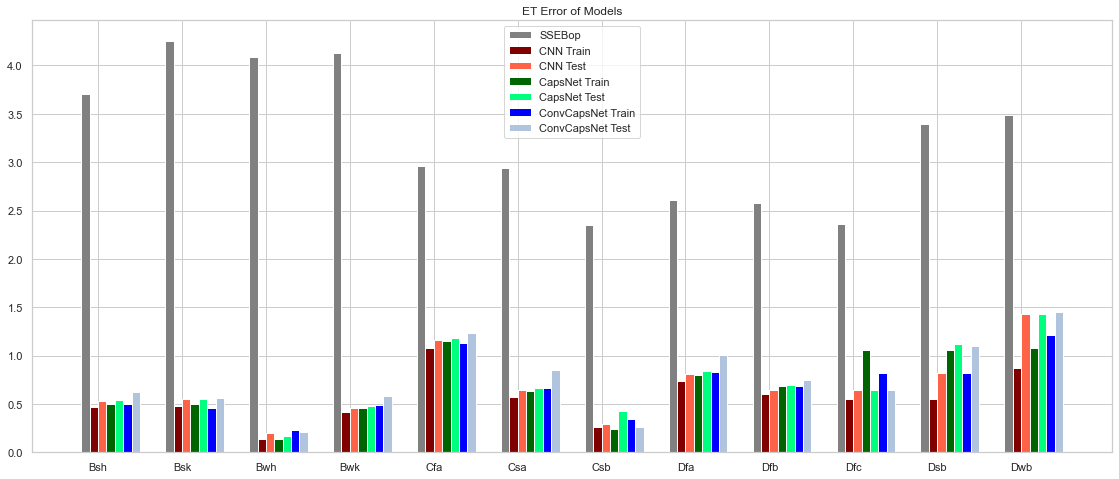

In [86]:
# data = [[30, 25, 50, 20],
# [40, 23, 51, 17],
# [35, 22, 45, 19]]


X = np.arange(12)
fig = plt.figure(figsize=(15, 6))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.0, data[0], color = 'grey', width = 0.10, label ='SSEBop')
ax.bar(X + 0.1, data[1], color = 'maroon', width = 0.10, label ='CNN Train')
ax.bar(X + 0.2, data[2], color = 'tomato', width = 0.10, label ='CNN Test')
ax.bar(X + 0.3, data[3], color = 'darkgreen', width = 0.10, label ='CapsNet Train')
ax.bar(X + 0.4, data[4], color = 'springgreen', width = 0.10, label ='CapsNet Test')
ax.bar(X + 0.5, data[5], color = 'blue', width = 0.10, label ='ConvCapsNet Train')
ax.bar(X + 0.6, data[6], color = 'lightsteelblue', width = 0.10, label ='ConvCapsNet Test')
plt.xticks([r + 0.15 for r in range(12)],
        ['Bsh','Bsk','Bwh','Bwk','Cfa','Csa','Csb','Dfa','Dfb','Dfc','Dsb','Dwb'])
plt.title("ET Error of Models")
plt.legend()

In [88]:
data = df.melt('Clim', var_name='Error', value_name='CNN_Train_Error')
print (data)

      Clim                Error CNN_Train_Error
0      Csa           Unnamed: 0               0
1      Csa           Unnamed: 0               1
2      Csa           Unnamed: 0               2
3      Csa           Unnamed: 0               3
4      Csa           Unnamed: 0               4
...    ...                  ...             ...
85342  Bsk  ConvCaps_Test_Error         0.46678
85343  Bsk  ConvCaps_Test_Error         0.38533
85344  Cfa  ConvCaps_Test_Error        2.203963
85345  Dfb  ConvCaps_Test_Error        0.542252
85346  Csa  ConvCaps_Test_Error         1.67439

[85347 rows x 3 columns]


<ipython-input-88-1f4b4b9fd6eb>:1: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  data = df.melt('Clim', var_name='Error', value_name='CNN_Train_Error')


[(0.0, 4.5)]

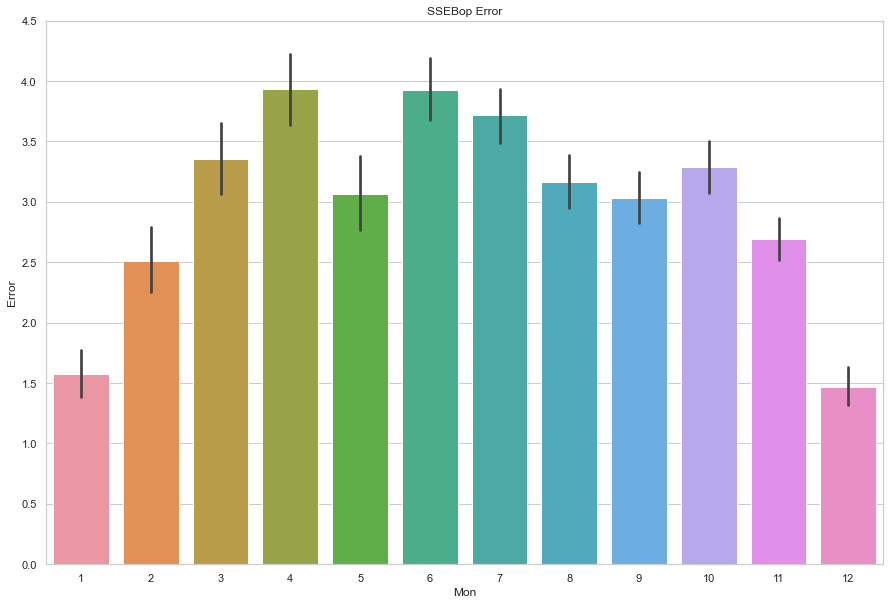

In [100]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.barplot(x="Mon", y="Error", data=df, ax=ax)
ax.set_title('SSEBop Error')
ax.set(ylim=(0, 4.5))

[(0.0, 4.5)]

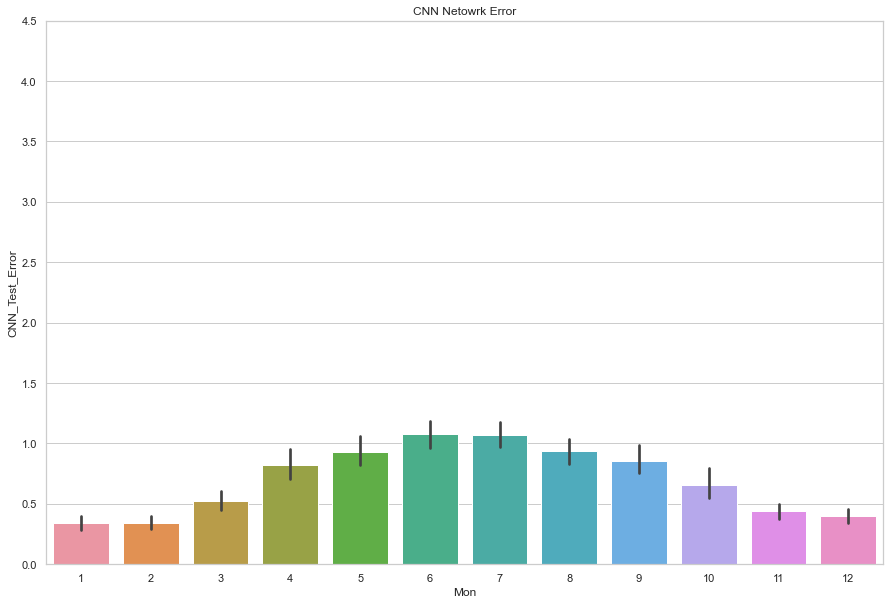

In [103]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.barplot(x="Mon", y="CNN_Test_Error", data=df, ax=ax)
ax.set_title('CNN Netowrk Error')
ax.set(ylim=(0, 4.5))

[(0.0, 4.5)]

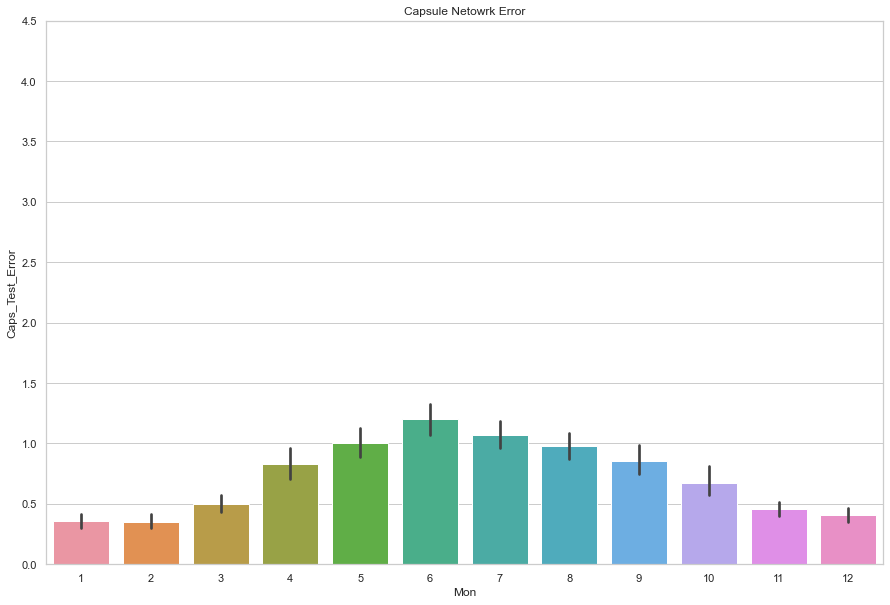

In [101]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.barplot(x="Mon", y="Caps_Test_Error", data=df, ax=ax)
ax.set_title('Capsule Netowrk Error')
ax.set(ylim=(0, 4.5))

[(0.0, 4.5)]

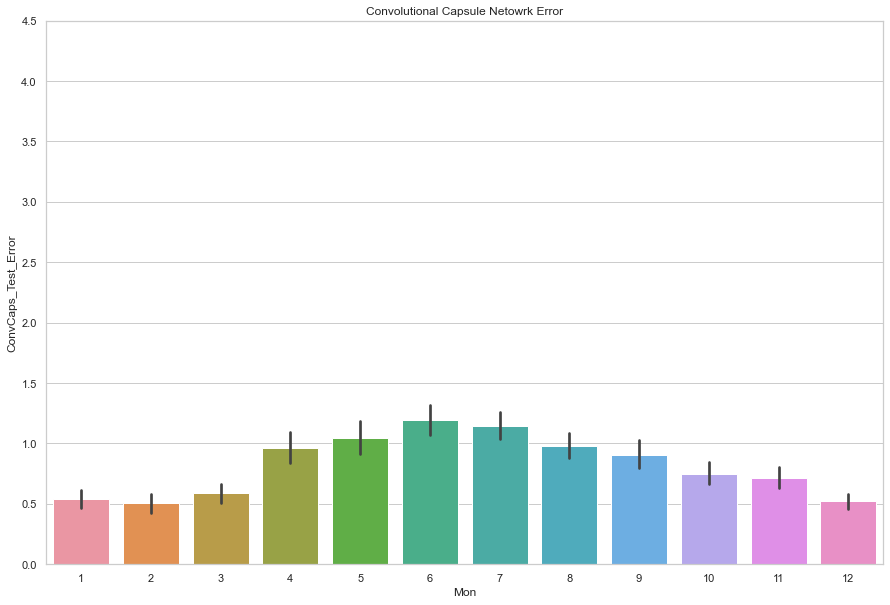

In [102]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.barplot(x="Mon", y="ConvCaps_Test_Error", data=df, ax=ax)
ax.set_title('Convolutional Capsule Netowrk Error')
ax.set(ylim=(0, 5.0))
ax.set(ylim=(0, 4.5))

[(0.0, 5.0)]

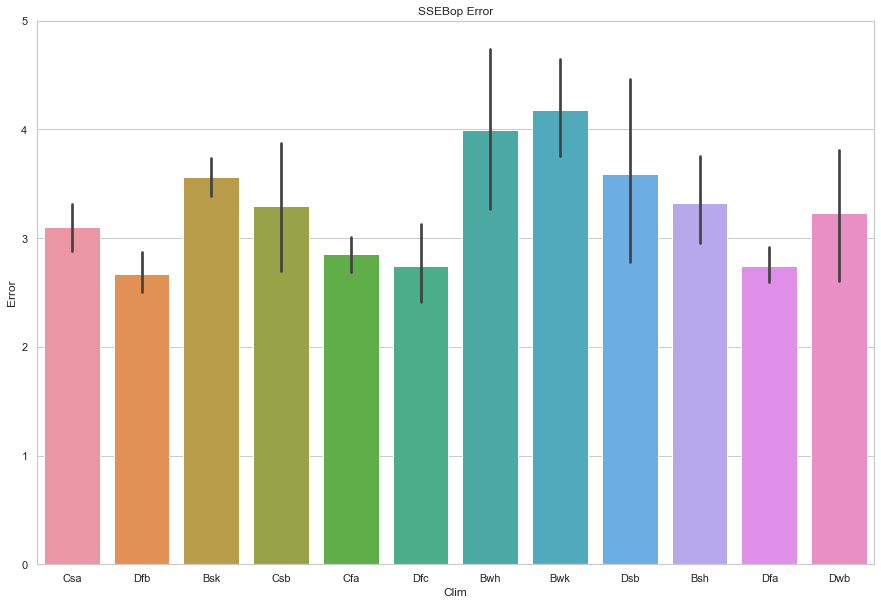

In [140]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.barplot(x="Clim", y="Error", data=df, ax=ax)
ax.set_title('SSEBop Error')
ax.set(ylim=(0, 5))

[(0.0, 5.0)]

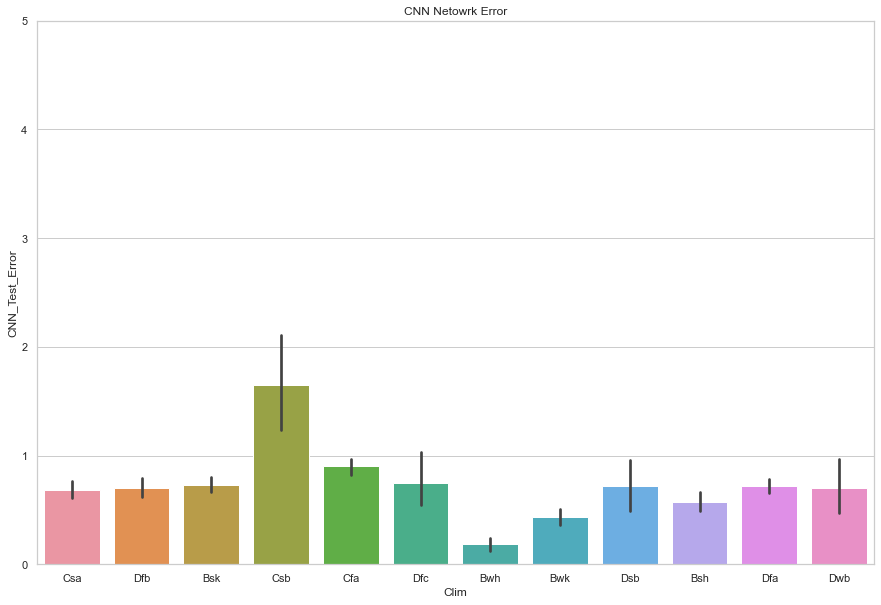

In [141]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.barplot(x="Clim", y="CNN_Test_Error", data=df, ax=ax)
ax.set_title('CNN Netowrk Error')
ax.set(ylim=(0, 5))

[(0.0, 5.0)]

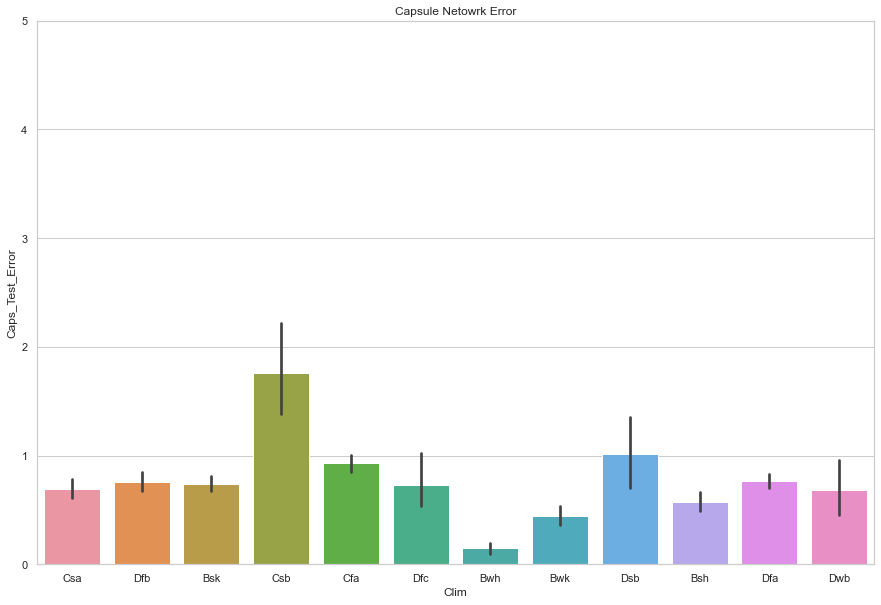

In [142]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.barplot(x="Clim", y="Caps_Test_Error", data=df, ax=ax)
ax.set_title('Capsule Netowrk Error')
ax.set(ylim=(0, 5))

[(0.0, 5.0)]

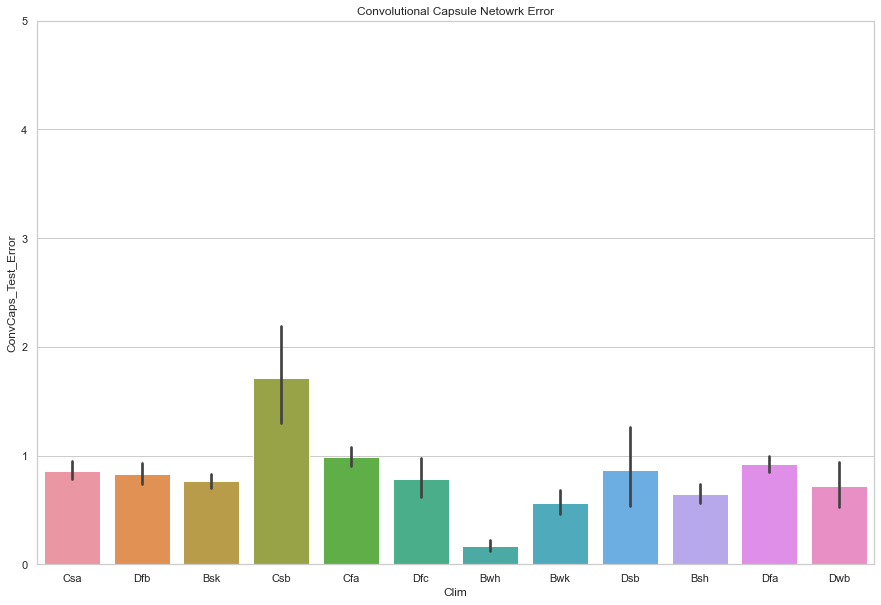

In [144]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.barplot(x="Clim", y="ConvCaps_Test_Error", data=df, ax=ax)
ax.set_title('Convolutional Capsule Netowrk Error')
ax.set(ylim=(0, 5))

[(0.0, 5.0)]

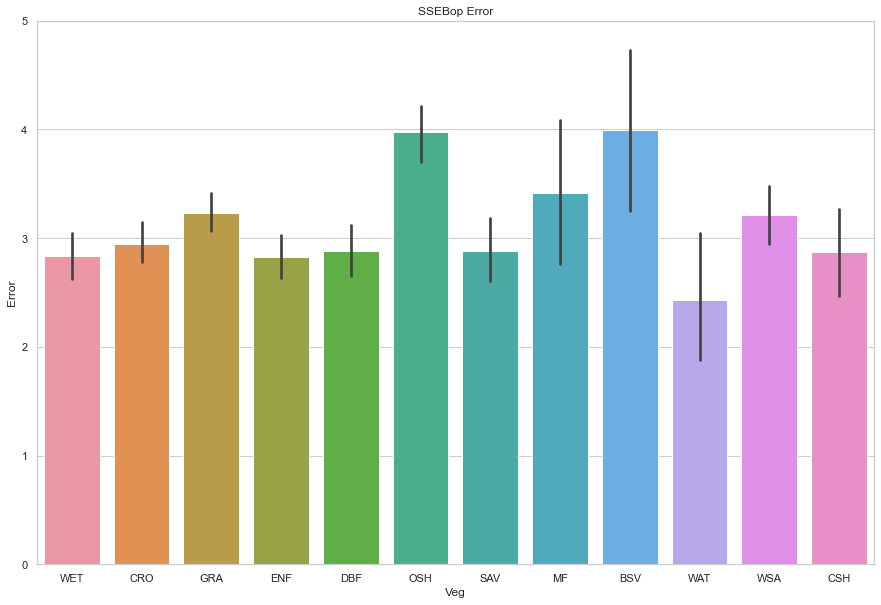

In [145]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.barplot(x="Veg", y="Error", data=df, ax=ax)
ax.set_title('SSEBop Error')
ax.set(ylim=(0, 5))

[(0.0, 5.0)]

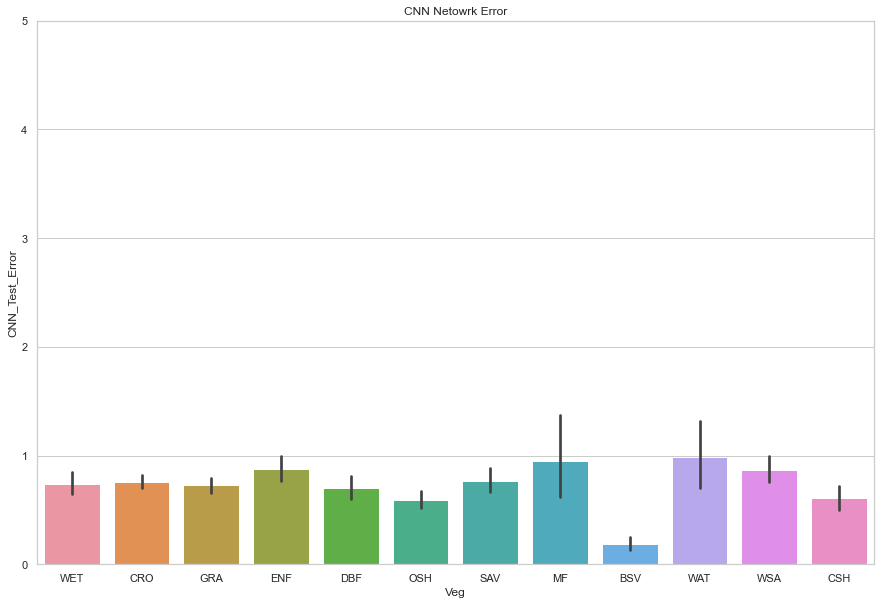

In [146]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.barplot(x="Veg", y="CNN_Test_Error", data=df, ax=ax)
ax.set_title('CNN Netowrk Error')
ax.set(ylim=(0, 5))

[(0.0, 5.0)]

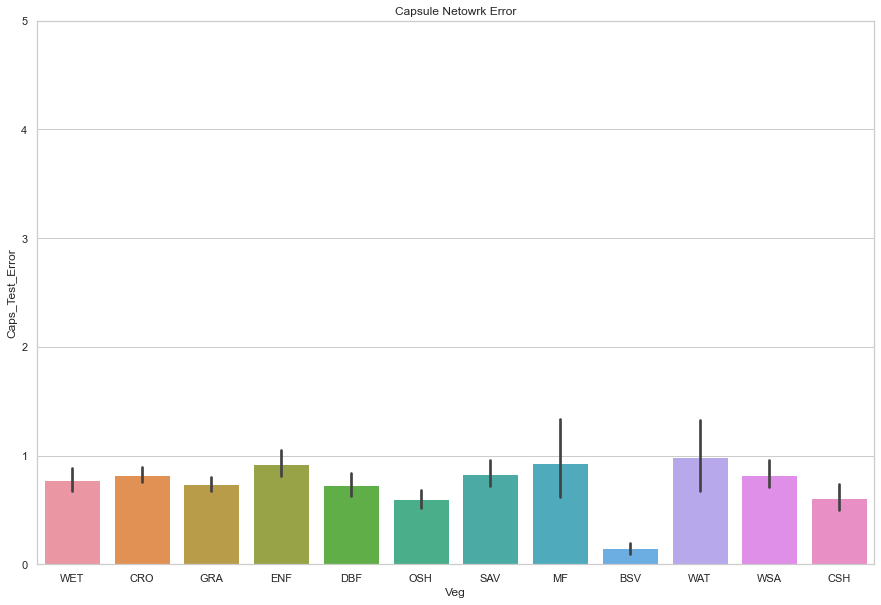

In [147]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.barplot(x="Veg", y="Caps_Test_Error", data=df, ax=ax)
ax.set_title('Capsule Netowrk Error')
ax.set(ylim=(0, 5))

[(0.0, 5.0)]

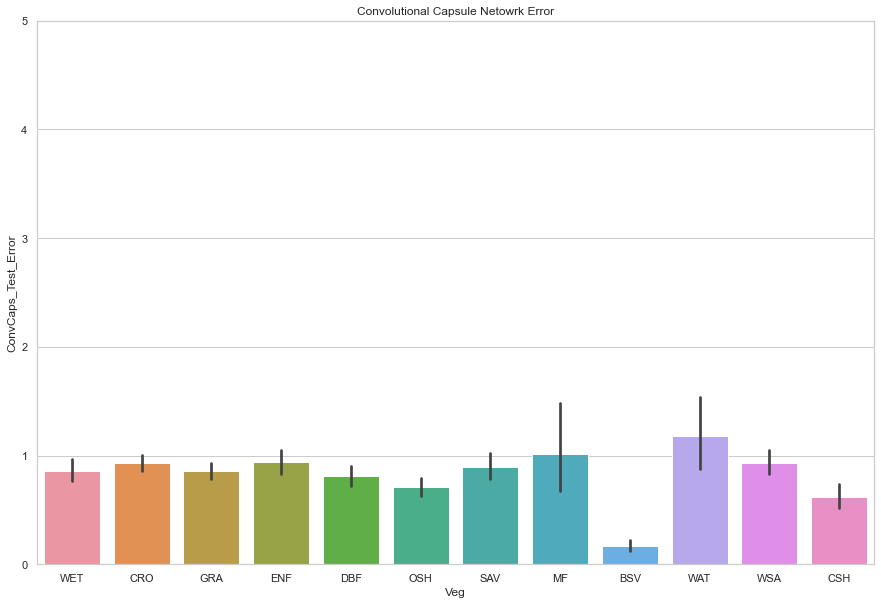

In [148]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.barplot(x="Veg", y="ConvCaps_Test_Error", data=df, ax=ax)
ax.set_title('Convolutional Capsule Netowrk Error')
ax.set(ylim=(0, 5))

In [122]:
df.columns

Index(['Unnamed: 0', 'Latitiude', 'Longitude', 'Error', 'SSEBop', 'Eddy',
       'Mon', 'Year', 'Day', 'CNN_Train_Output', 'CNN_Test_Output',
       'CNN_Train_Error', 'CNN_Test_Error', 'Caps_Train_Output',
       'Caps_Test_Output', 'Caps_Train_Error', 'Caps_Test_Error',
       'ConvCaps_Train_Output', 'ConvCaps_Test_Output', 'ConvCaps_Train_Error',
       'ConvCaps_Test_Error', 'text'],
      dtype='object')

ValueError: Could not interpret input 'Clim'

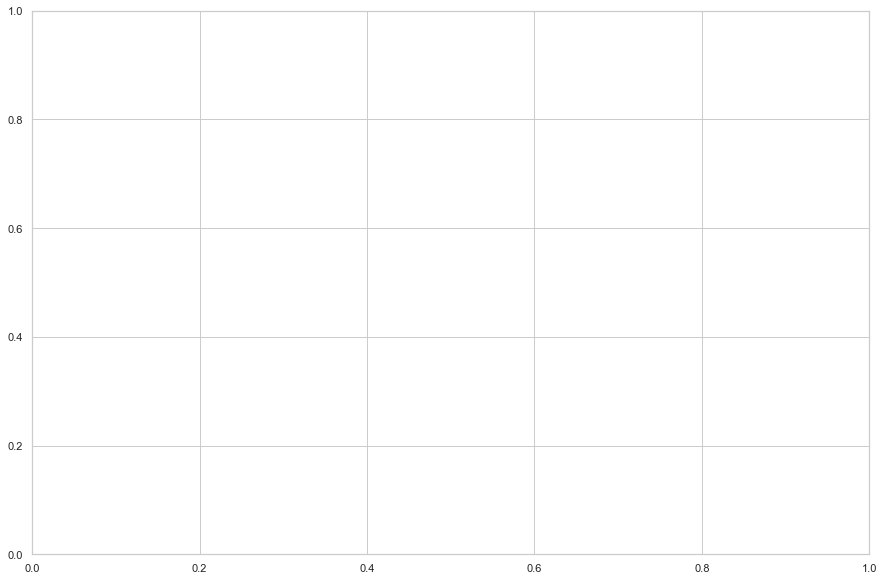

In [120]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.barplot(x="Clim", y="Error", data=df, ax=ax)
ax.set_title('SSEBop Error')
ax.set(ylim=(0, 4.5))

[(0.0, 4.5)]

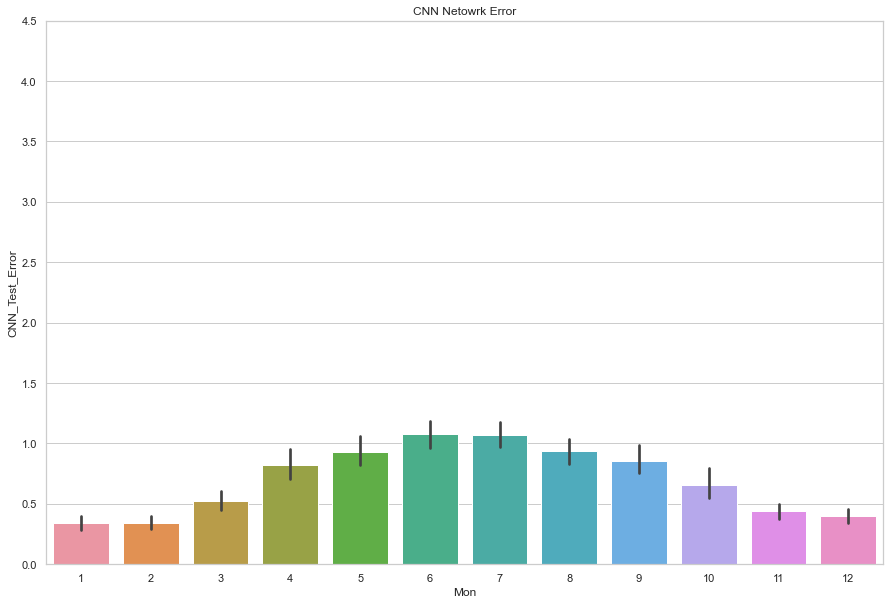

In [103]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.barplot(x="Mon", y="CNN_Test_Error", data=df, ax=ax)
ax.set_title('CNN Netowrk Error')
ax.set(ylim=(0, 4.5))

[(0.0, 4.5)]

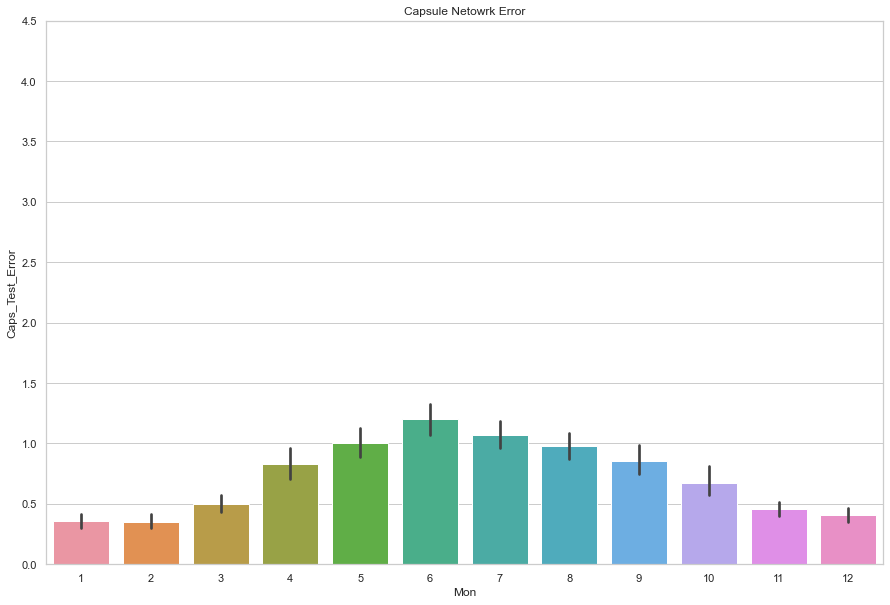

In [101]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.barplot(x="Mon", y="Caps_Test_Error", data=df, ax=ax)
ax.set_title('Capsule Netowrk Error')
ax.set(ylim=(0, 4.5))

[(0.0, 4.5)]

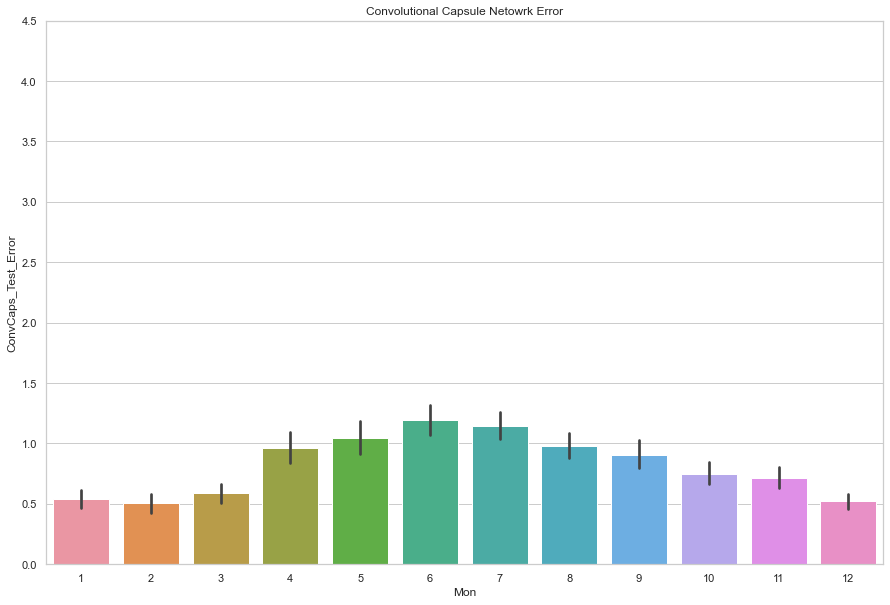

In [102]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.barplot(x="Mon", y="ConvCaps_Test_Error", data=df, ax=ax)
ax.set_title('Convolutional Capsule Netowrk Error')
ax.set(ylim=(0, 5.0))
ax.set(ylim=(0, 4.5))

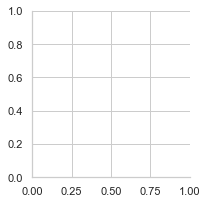

In [25]:
sns.FacetGrid(df)

In [26]:
# g = sns.FacetGrid(df, col="Clim", col_wrap=4, aspect=1.7)
# g.map(sns.barplot, "Eddy", "SSEBop")

In [178]:
df["Clim"]

0       Csa
1       Csa
2       Csa
3       Csa
4       Csa
       ... 
3156    Csa
3157    Csa
3158    Csa
3159    Csa
3160    Csa
Name: Clim, Length: 3161, dtype: object

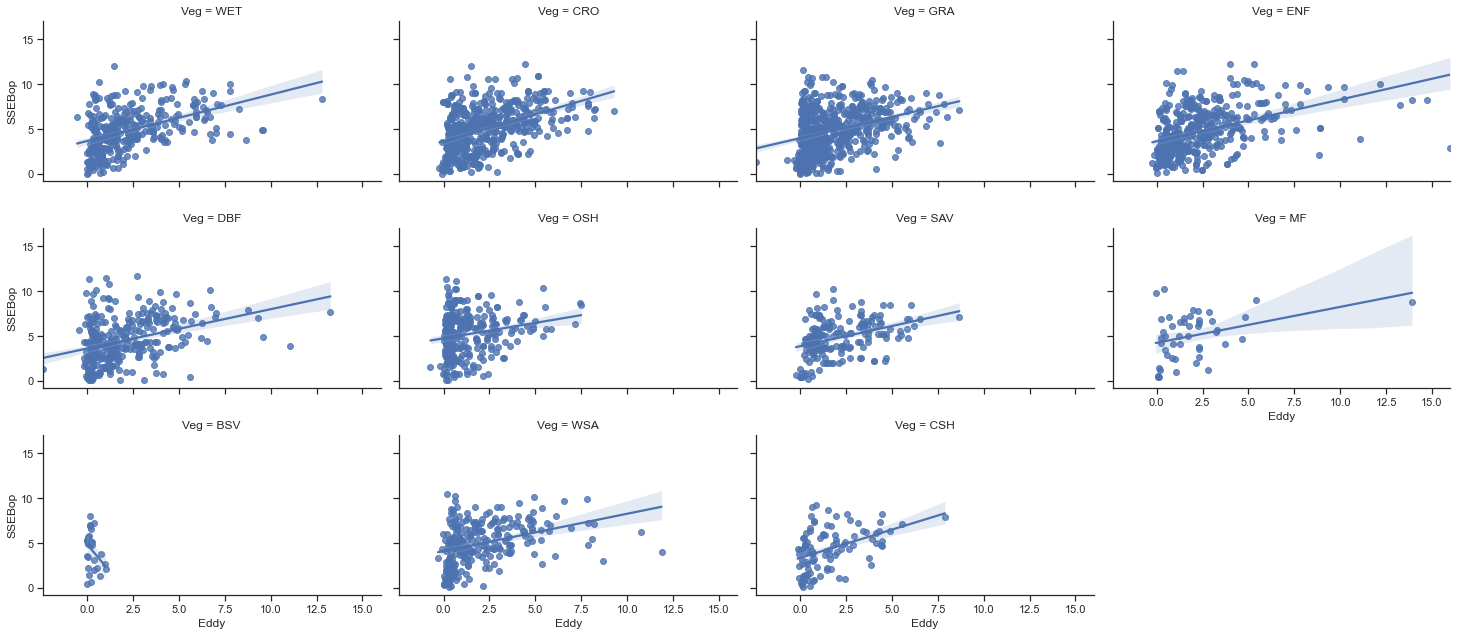

In [179]:
g = sns.FacetGrid(df[df["Veg"] != "WAT"], col="Veg", col_wrap=4, aspect=1.7)
g.map(sns.regplot, "Eddy", "SSEBop")

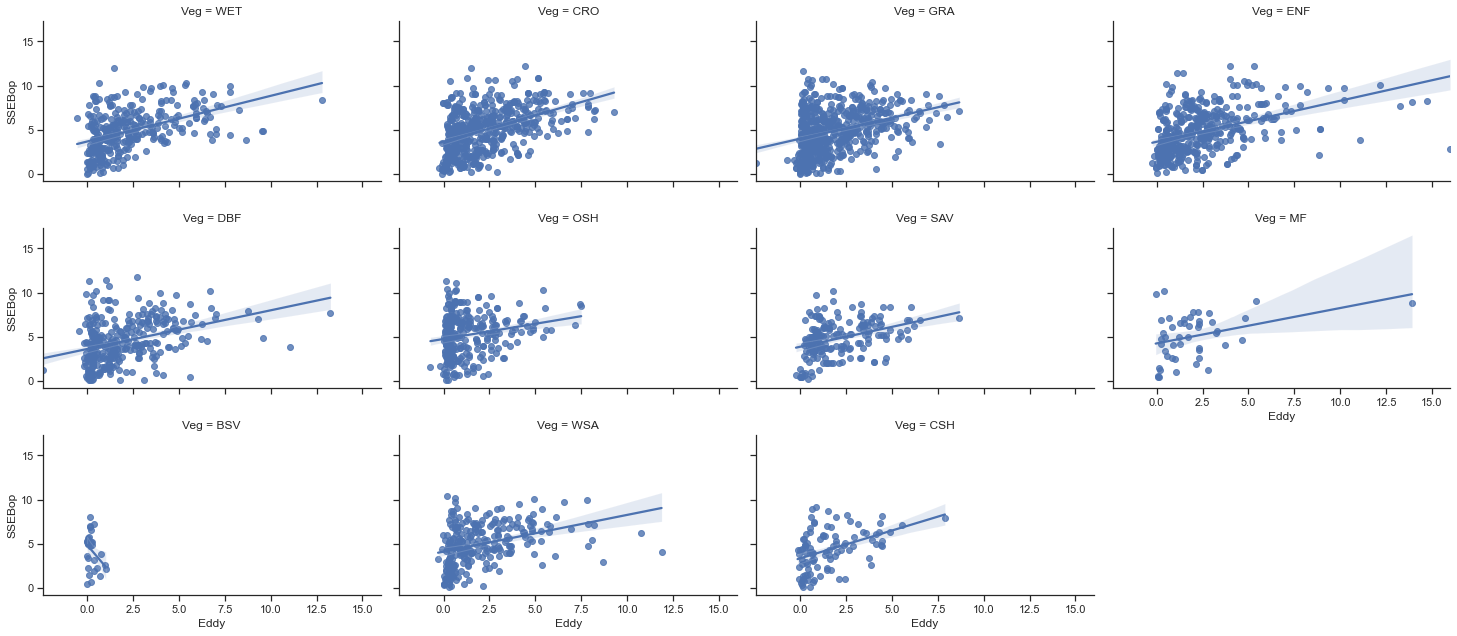

In [181]:
g = sns.FacetGrid(df[df["Veg"] != "WAT"], col="Veg", col_wrap=4, aspect=1.7)
g.map(sns.regplot, "Eddy", "SSEBop")

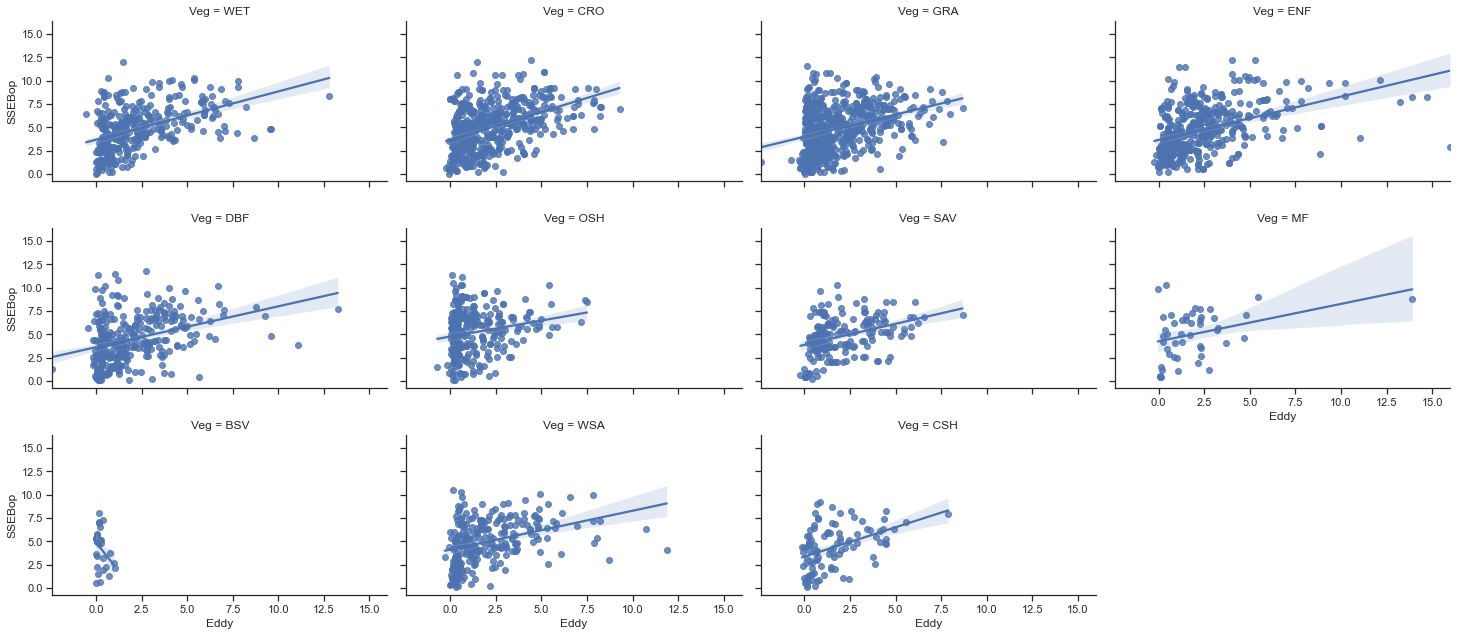

In [184]:
g = sns.FacetGrid(df[df["Veg"] != "WAT"], col="Veg", col_wrap=4, aspect=1.7)
g.map(sns.regplot, "Eddy", "SSEBop")

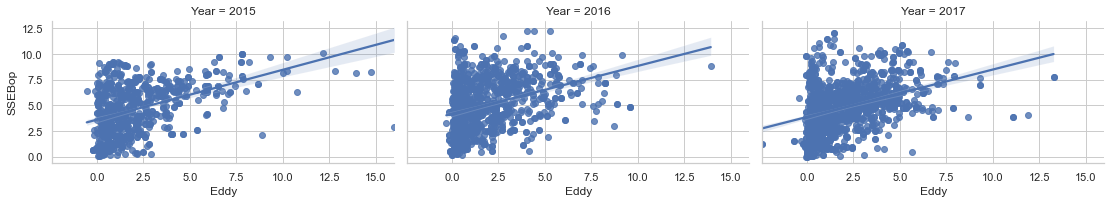

In [30]:
g = sns.FacetGrid(df, col="Year", col_wrap=4, aspect=1.7)
g.map(sns.regplot, "Eddy", "SSEBop")

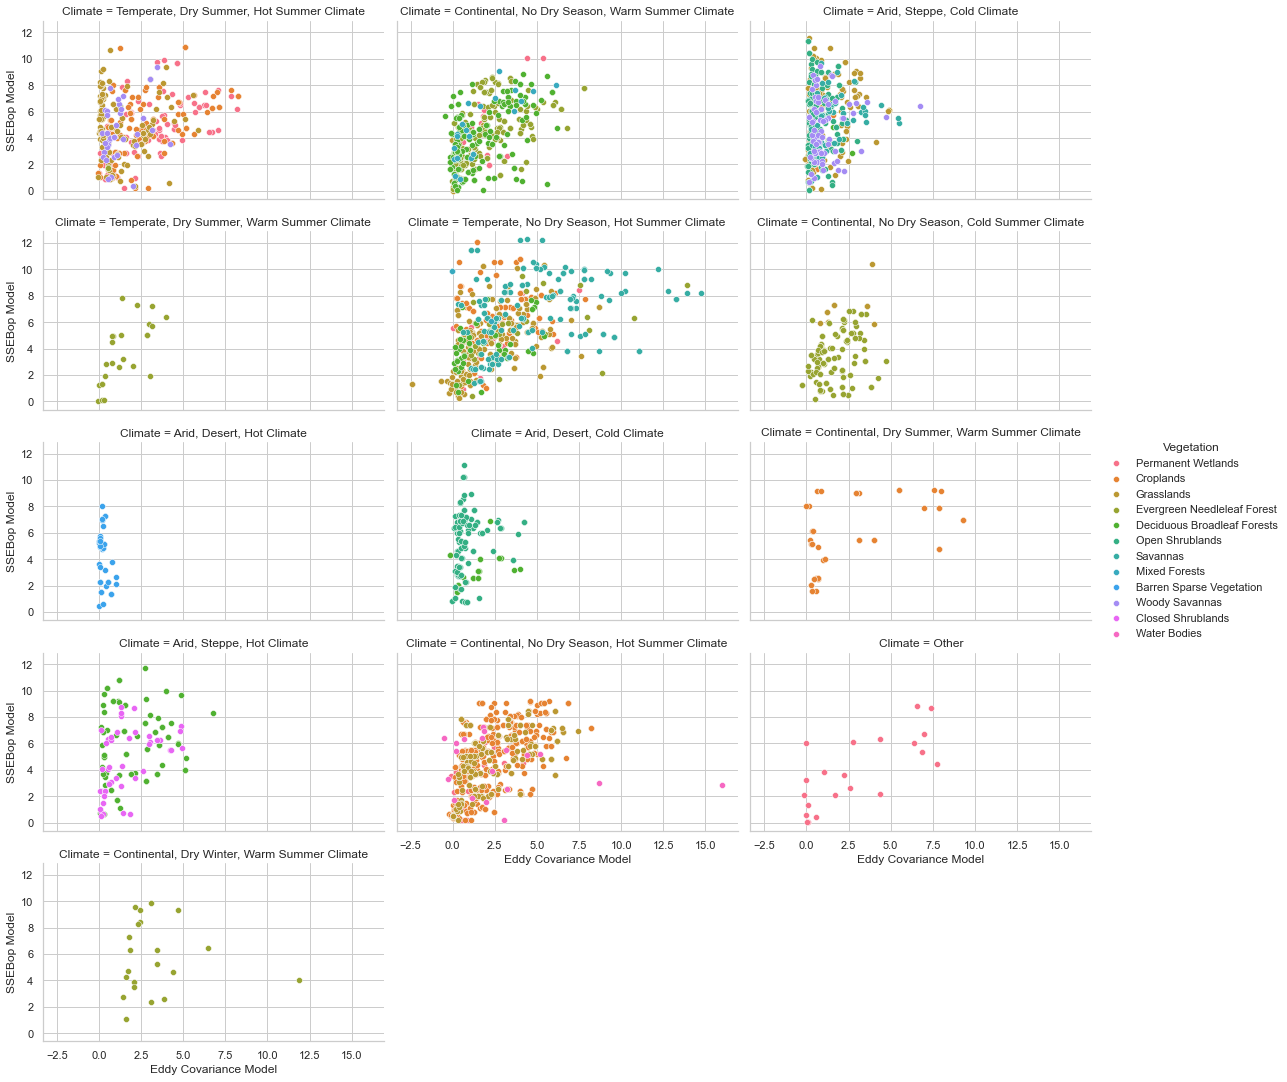

In [31]:
g = sns.FacetGrid(df, col="Climate", hue="Vegetation", col_wrap=3, aspect=1.7)
g.map_dataframe(sns.scatterplot, x="Eddy", y="SSEBop")
g.set_axis_labels("Eddy Covariance Model", "SSEBop Model")
g.add_legend()

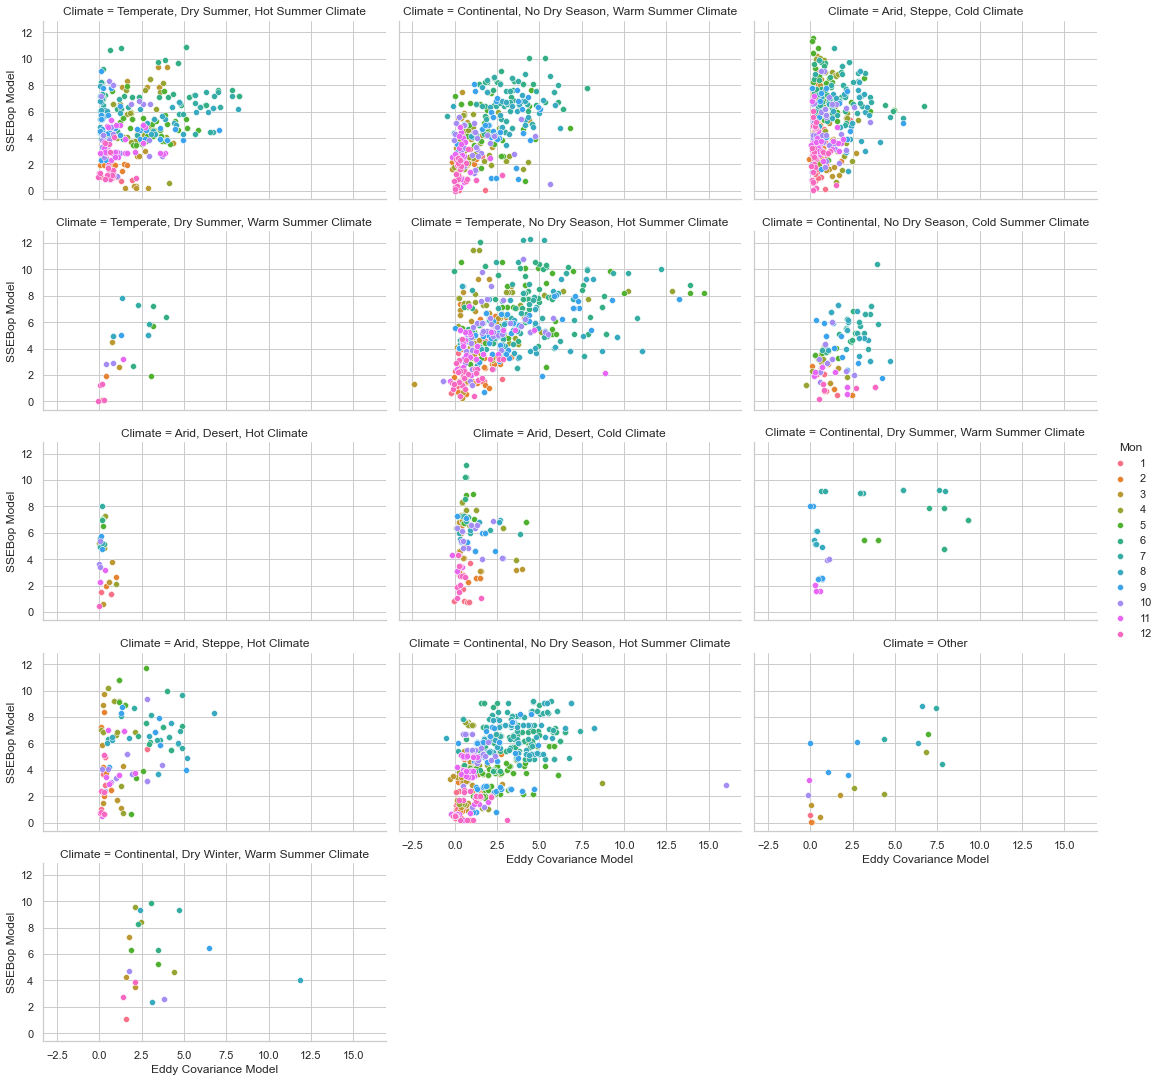

In [32]:
g = sns.FacetGrid(df, col="Climate", hue="Mon", col_wrap=3, aspect=1.7)
g.map_dataframe(sns.scatterplot, x="Eddy", y="SSEBop")
g.set_axis_labels("Eddy Covariance Model", "SSEBop Model")
g.add_legend()

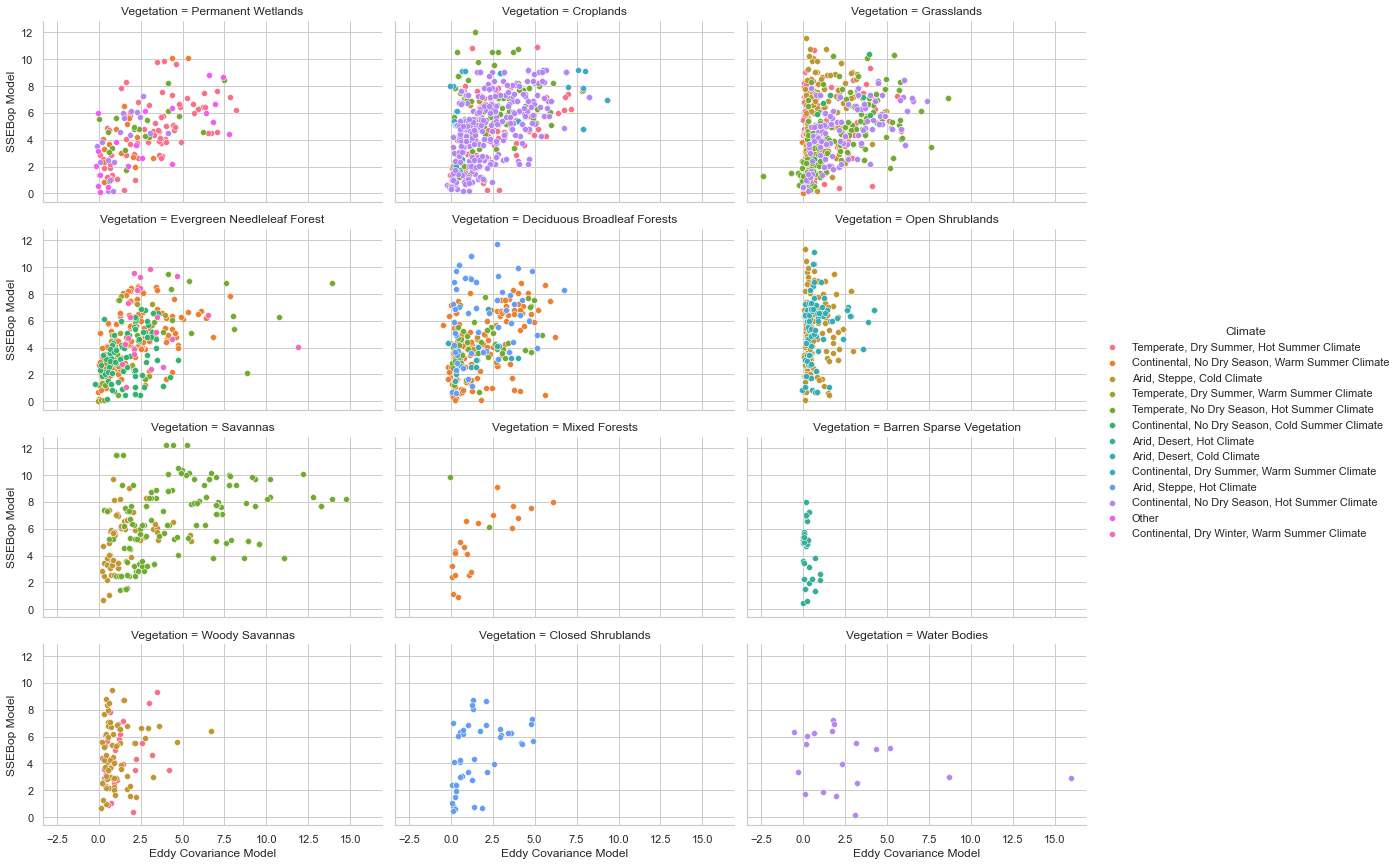

In [33]:
g = sns.FacetGrid(df, col="Vegetation", hue="Climate", col_wrap=3, aspect=1.7)
g.map_dataframe(sns.scatterplot, x="Eddy", y="SSEBop")
g.set_axis_labels("Eddy Covariance Model", "SSEBop Model")
g.add_legend()

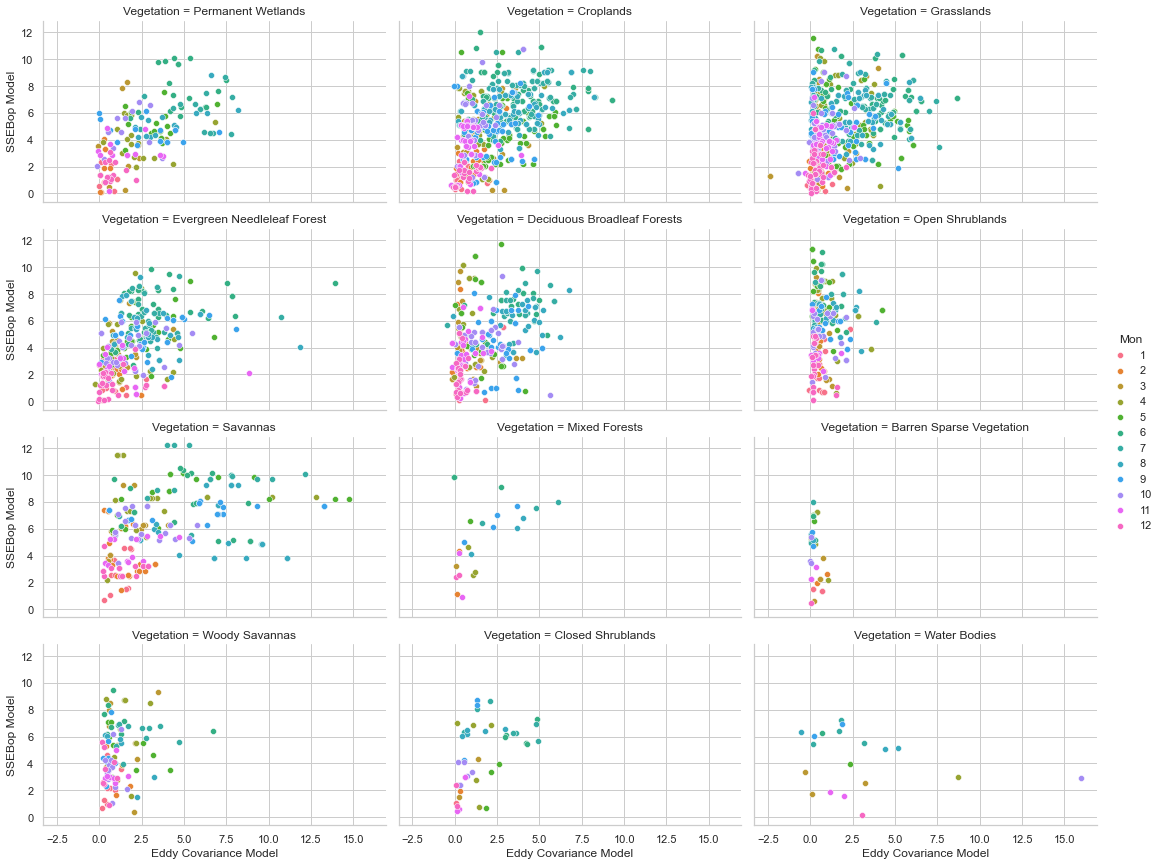

In [34]:
g = sns.FacetGrid(df, col="Vegetation", hue="Mon", col_wrap=3, aspect=1.7)
g.map_dataframe(sns.scatterplot, x="Eddy", y="SSEBop")
g.set_axis_labels("Eddy Covariance Model", "SSEBop Model")
g.add_legend()

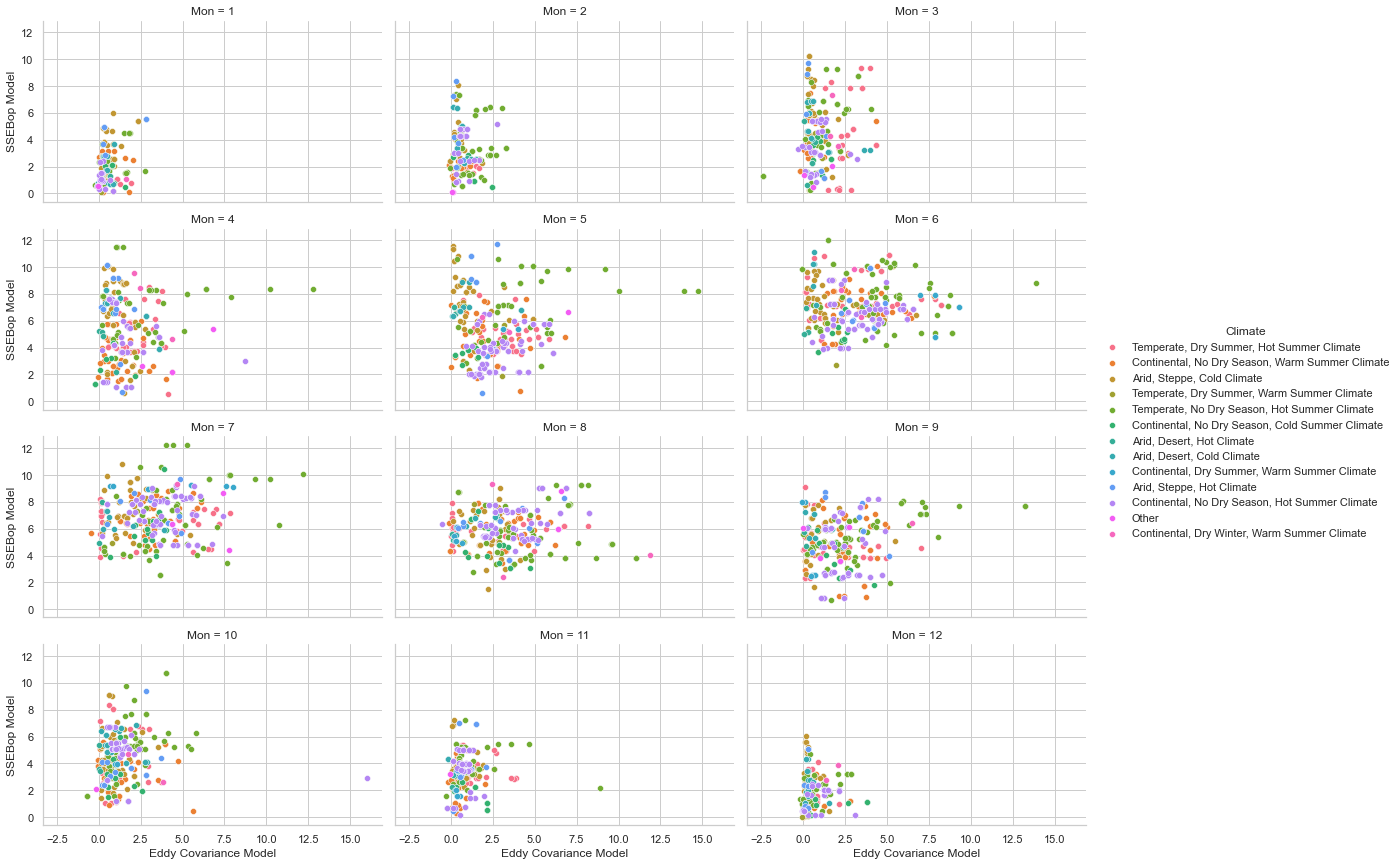

In [35]:
g = sns.FacetGrid(df, col="Mon", hue="Climate", col_wrap=3, aspect=1.7)
g.map_dataframe(sns.scatterplot, x="Eddy", y="SSEBop")
g.set_axis_labels("Eddy Covariance Model", "SSEBop Model")
g.add_legend()

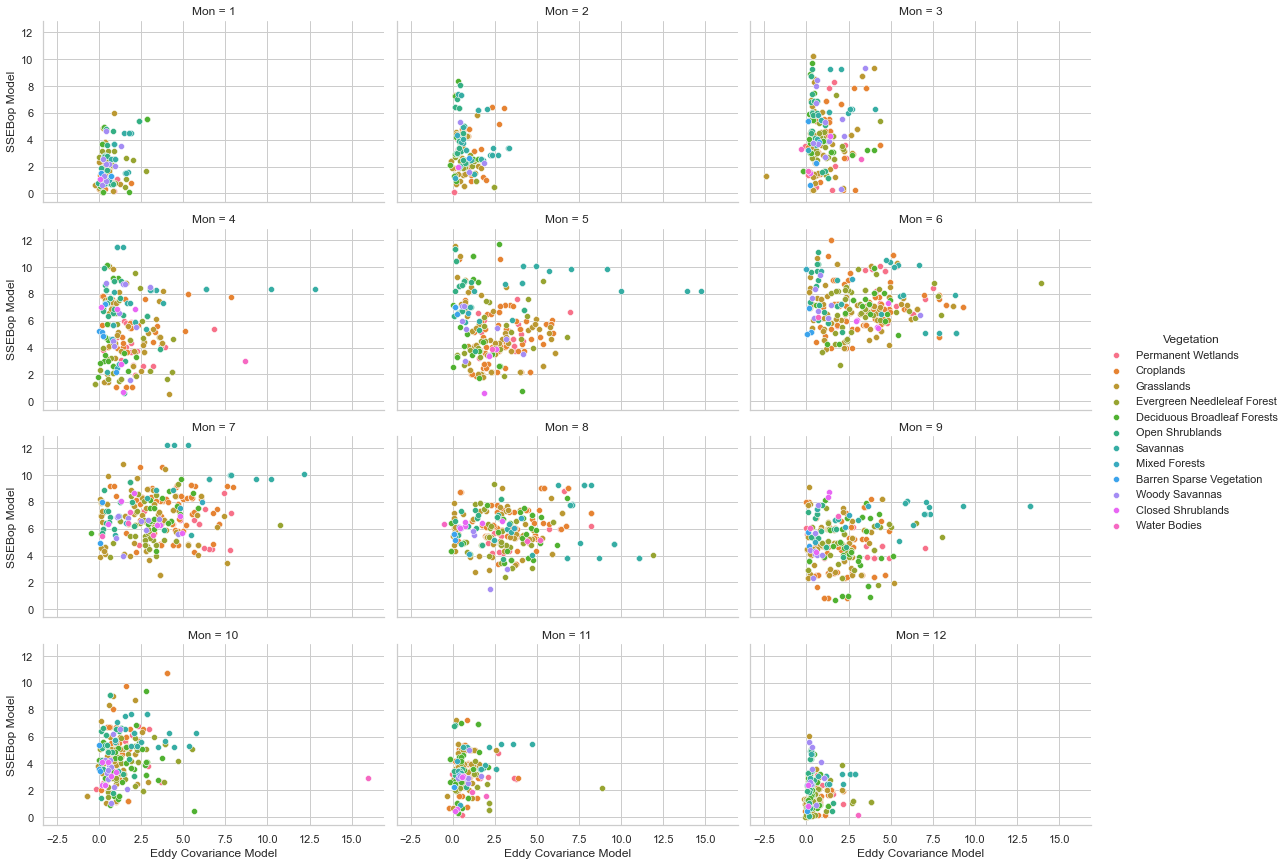

In [36]:
g = sns.FacetGrid(df, col="Mon", hue="Vegetation", col_wrap=3, aspect=1.7)
g.map_dataframe(sns.scatterplot, x="Eddy", y="SSEBop")
g.set_axis_labels("Eddy Covariance Model", "SSEBop Model")
g.add_legend()

In [ ]:
df.corr()

In [ ]:
df.columns

In [ ]:
temp = df[df['Month'] =='January'].corr()
print("January " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='February'].corr()
print("February " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='March'].corr()
print("March " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='April'].corr()
print("April " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='May'].corr()
print("May " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='June'].corr()
print("June " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='July'].corr()
print("July " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='August'].corr()
print("August " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='September'].corr()
print("September " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='October'].corr()
print("October " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='November'].corr()
print("November " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='December'].corr()
print("December " + str(temp["SSEBop"]["Eddy"]))

In [ ]:
# temp = df[df['Climate'] =='Temperate, Dry Winter, Hot Summer Climate'].corr()
# print("Temperate, Dry Winter, Hot Summer Climate " + str(temp["SSEBop"]["Eddy"]))
# temp = df[df['Climate'] =='Continental, Dry Winter, Cold Summer Climate'].corr()
# print("Continental, Dry Winter, Cold Summer Climate " + str(temp["SSEBop"]["Eddy"]))
# temp = df[df['Climate'] =='Polar, Tundra'].corr()
# print("Polar, Tundra " + str(temp["SSEBop"]["Eddy"]))

In [ ]:
temp = df[df['Climate'] =='Arid, Steppe, Hot Climate'].corr()
print("Arid, Steppe, Hot Climate " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Climate'] =='Arid, Steppe, Cold Climate'].corr()
print("Arid, Steppe, Cold Climate " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Climate'] =='Arid, Desert, Hot Climate'].corr()
print("Arid, Desert, Hot Climate " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Climate'] =='Arid, Desert, Cold Climate'].corr()
print("Arid, Desert, Cold Climate " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Climate'] =='Temperate, No Dry Season, Hot Summer Climate'].corr()
print("Temperate, No Dry Season, Hot Summer Climate " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Climate'] =='Temperate, Dry Summer, Hot Summer Climate'].corr()
print("Temperate, Dry Summer, Hot Summer Climate " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Climate'] =='Temperate, Dry Summer, Warm Summer Climate'].corr()
print("Temperate, Dry Summer, Warm Summer Climate " + str(temp["SSEBop"]["Eddy"]))
print("Temperate, Dry Winter, Hot Summer Climate " + str(0))
temp = df[df['Climate'] =='Continental, Dry Summer, Warm Summer Climate'].corr()
print("Continental, Dry Summer, Warm Summer Climate " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Climate'] =='Continental, No Dry Season, Hot Summer Climate'].corr()
print("Continental, No Dry Season, Hot Summer Climate " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Climate'] =='Continental, No Dry Season, Warm Summer Climate'].corr()
print("Continental, No Dry Season, Warm Summer Climate " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Climate'] =='Continental, No Dry Season, Cold Summer Climate'].corr()
print("Continental, No Dry Season, Cold Summer Climate " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Climate'] =='Continental, Dry Winter, Warm Summer Climate'].corr()
print("Continental, Dry Winter, Warm Summer Climate " + str(temp["SSEBop"]["Eddy"]))
print("Continental, Dry Winter, Cold Summer Climate " + str(0))
temp = df[df['Climate'] =='Other'].corr()
print("Polar, Tundra " + str(0))
print("Other " + str(temp["SSEBop"]["Eddy"]))

In [ ]:
veg_dict = {
    "BSV": "Barren Sparse Vegetation",
    "CRO": "Croplands",
    "CSH": "Closed Shrublands",
    "CVM": "Cropland/Natural Vegetation Mosaics",
    "DBF": "Deciduous Broadleaf Forests",
    "DNF": "Deciduous Needleleaf Forests",
    "EBF": "Evergreen Broadleaf Forests",
    "ENF": "Evergreen Needleleaf Forest",
    "GRA": "Grasslands",
    "MF": "Mixed Forests",
    "OSH": "Open Shrublands",
    "SAV": "Savannas",
    "SNO": "Snow and Ice",
    "URB": "Urban and Built-Up Lands",
    "WAT": "Water Bodies",
    "WET": "Permanent Wetlands",
    "WSA": "Woody Savannas",
}

In [172]:
temp = df[df['Vegetation'] =='Barren Sparse Vegetation'].corr()
print("Barren Sparse Vegetation " + str(temp["SSEBop"]["Eddy"]))

temp = df[df['Vegetation'] =='Croplands'].corr()
print("Croplands " + str(temp["SSEBop"]["Eddy"]))

temp = df[df['Vegetation'] =='Closed Shrublands'].corr()
print("Closed Shrublands " + str(temp["SSEBop"]["Eddy"]))

temp = df[df['Vegetation'] =='Deciduous Broadleaf Forests'].corr()
print("Deciduous Broadleaf Forests " + str(temp["SSEBop"]["Eddy"]))

temp = df[df['Vegetation'] =='Evergreen Needleleaf Forest'].corr()
print("Evergreen Needleleaf Forest " + str(temp["SSEBop"]["Eddy"]))

temp = df[df['Vegetation'] =='Grasslands'].corr()
print("Grasslands " + str(temp["SSEBop"]["Eddy"]))

temp = df[df['Vegetation'] =='Mixed Forests'].corr()
print("Mixed Forests " + str(temp["SSEBop"]["Eddy"]))

temp = df[df['Vegetation'] =='Open Shrublands'].corr()
print("Open Shrublands " + str(temp["SSEBop"]["Eddy"]))

temp = df[df['Vegetation'] =='Savannas'].corr()
print("Savannas " + str(temp["SSEBop"]["Eddy"]))

temp = df[df['Vegetation'] =='Permanent Wetlands'].corr()
print("Permanent Wetlands " + str(temp["SSEBop"]["Eddy"]))

temp = df[df['Vegetation'] =='Woody Savannas'].corr()
print("Woody Savannas " + str(temp["SSEBop"]["Eddy"]))

Barren Sparse Vegetation -0.3400815425683797
Croplands 0.4781711851273327
Closed Shrublands 0.4733143229078173
Deciduous Broadleaf Forests 0.41880934058589686
Evergreen Needleleaf Forest 0.4706214251427206
Grasslands 0.3244845317741139
Mixed Forests 0.47007997806461327
Open Shrublands 0.10972774972560534
Savannas 0.42448545909794566
Permanent Wetlands 0.597964723302978
Woody Savannas 0.17855685797570955


In [ ]:
temp = df[df['Month'] =='January'].corr()
print("January " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='February'].corr()
print("February " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='March'].corr()
print("March " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='April'].corr()
print("April " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='May'].corr()
print("May " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='June'].corr()
print("June " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='July'].corr()
print("July " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='August'].corr()
print("August " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='September'].corr()
print("September " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='October'].corr()
print("October " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='November'].corr()
print("November " + str(temp["SSEBop"]["Eddy"]))
temp = df[df['Month'] =='December'].corr()
print("December " + str(temp["SSEBop"]["Eddy"]))

In [ ]:
np.average(df['SSEBop'] - df['Eddy'])

# Cloudy ML Results

# ResNet

In [ ]:
resnet = glob.glob("results/ResNet*.txt")

In [ ]:
for file in resnet:
    f = open(file, "r")
    print(file)
    ary = []
    for x in f:
        ary.append(float(x))
    print(ary)

In [ ]:
import os
os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share"; #fixr
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [ ]:
map = Basemap()

map.drawcoastlines()

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import pandas as pd

In [1]:
df

NameError: name 'df' is not defined

In [105]:
import plotly.express as px
df = px.data.gapminder().query("year == 2007")
fig = px.scatter_geo(df, locations="iso_alpha",
                     color="continent", # which column to use to set the color of markers
                     hover_name="country", # column added to hover information
                     size="pop", # size of markers
                     projection="natural earth")
fig.show()

In [9]:
df

iata                            airport               city state country  \
0    ORD       Chicago O'Hare International            Chicago    IL     USA   
1    ATL  William B Hartsfield-Atlanta Intl            Atlanta    GA     USA   
2    DFW    Dallas-Fort Worth International  Dallas-Fort Worth    TX     USA   
3    PHX   Phoenix Sky Harbor International            Phoenix    AZ     USA   
4    DEN                        Denver Intl             Denver    CO     USA   
..   ...                                ...                ...   ...     ...   
216  EAU           Chippewa Valley Regional         Eau Claire    WI     USA   
217  DBQ                  Dubuque Municipal            Dubuque    IA     USA   
218  RST            Rochester International          Rochester    MN     USA   
219  UTM           Tunica Municipal Airport             Tunica    MS     USA   
220  BIL                Billings Logan Intl           Billings    MT     USA   

           lat        long    cnt  \
0    41.979595  -87.904464  25129   
1    33.640444  -84.426944  21925   
2    32.895951  -97.037200  20662   
3    33.434167 -112.008056  17290   
4    39.858408 -104.667002  13781   
..         ...         ...    ...   
216  44.865257  -91.485072     48   
217  42.402959  -90.709167     48   
218  43.908826  -92.497987     37   
219  34.681499  -90.348816     32   
220  45.807662 -108.542861     23   

                                                  text  
0    Chicago O'Hare InternationalChicago, ILArrival...  
1    William B Hartsfield-Atlanta IntlAtlanta, GAAr...  
2    Dallas-Fort Worth InternationalDallas-Fort Wor...  
3    Phoenix Sky Harbor InternationalPhoenix, AZArr...  
4                 Denver IntlDenver, COArrivals: 13781  
..                                                 ...  
216  Chippewa Valley RegionalEau Claire, WIArrivals...  
217           Dubuque MunicipalDubuque, IAArrivals: 48  
218   Rochester InternationalRochester, MNArrivals: 37  
219     Tunica Municipal AirportTunica, MSArrivals: 32  
220        Billings Logan IntlBillings, MTArrivals: 23  

[221 rows x 9 columns]

In [11]:
df

Unnamed: 0  Latitiude  Longitude Site_ID     Error     SSEBop      Eddy  \
0              0    38.1027  -121.6413  US-Tw4  1.440416   3.068682  1.628266   
1              1    38.1027  -121.6413  US-Tw4  0.539789   5.007730  4.467941   
2              2    38.1027  -121.6413  US-Tw4  5.653532  10.292969  4.639437   
3              3    38.1027  -121.6413  US-Tw4  0.386391   4.335000  3.948609   
4              4    38.1027  -121.6413  US-Tw4  1.356487   4.930000  3.573513   
...          ...        ...        ...     ...       ...        ...       ...   
3550        3550    38.1027  -121.6413  US-Tw4  3.474769   7.991413  4.516644   
3551        3551    38.1027  -121.6413  US-Tw4  0.493210   2.818826  2.325616   
3552        3552    38.1027  -121.6413  US-Tw4  0.814831   7.565000  6.750170   
3553        3553    38.1027  -121.6413  US-Tw4  1.616301   1.190000  2.806301   
3554        3554    38.1027  -121.6413  US-Tw4  1.410677   7.047730  5.637054   

      Mon      Month  Year  ...          Vegetation Geohash CNN_Train_Output  \
0      11   November  2015  ...  Permanent Wetlands    9qc2         1.368125   
1       9  September  2017  ...  Permanent Wetlands    9qc2         5.404996   
2       6       June  2017  ...  Permanent Wetlands    9qc2         5.105434   
3       4      April  2015  ...  Permanent Wetlands    9qc2         2.582875   
4       5        May  2017  ...  Permanent Wetlands    9qc2         3.436983   
...   ...        ...   ...  ...                 ...     ...              ...   
3550    5        May  2016  ...  Permanent Wetlands    9qc2         3.804014   
3551    3      March  2015  ...  Permanent Wetlands    9qc2         1.725005   
3552    6       June  2016  ...  Permanent Wetlands    9qc2         5.373691   
3553   10    October  2015  ...  Permanent Wetlands    9qc2         2.182071   
3554    7       July  2017  ...  Permanent Wetlands    9qc2         6.191298   

     CNN_Test_Output CNN_Train_Error CNN_Test_Error  ResNet_Train_Output  \
0           1.508427        0.260141       0.119840             1.392040   
1           5.771926        0.937055       1.303985             4.044652   
2           4.944929        0.465998       0.305492             4.041492   
3                NaN        1.365734            NaN             2.773085   
4           3.180310        0.136530       0.393203             3.049776   
...              ...             ...            ...                  ...   
3550        3.777442        0.712630       0.739202             3.038820   
3551        1.693307        0.600611       0.632308             2.110907   
3552        5.004218        1.376479       1.745952             3.636755   
3553        2.094576        0.624230       0.711725             2.063972   
3554        6.301709        0.554245       0.664656             3.360727   

      ResNet_Test_Output  ResNet_Train_Error  ResNet_Test_Error  
0               1.618021            0.236227           0.010246  
1               3.954798            0.423289           0.513144  
2               3.343529            0.597945           1.295907  
3                    NaN            1.175524                NaN  
4               3.341966            0.523737           0.231547  
...                  ...                 ...                ...  
3550            2.781890            1.477824           1.734754  
3551            1.532155            0.214709           0.793461  
3552            3.431051            3.113415           3.319118  
3553            1.251846            0.742329           1.554456  
3554            3.673880            2.276327           1.963173  

[3555 rows x 24 columns]

In [17]:
df

Unnamed: 0  Latitiude  Longitude Site_ID     Error     SSEBop      Eddy  \
0              0    38.1027  -121.6413  US-Tw4  1.440416   3.068682  1.628266   
1              1    38.1027  -121.6413  US-Tw4  0.539789   5.007730  4.467941   
2              2    38.1027  -121.6413  US-Tw4  5.653532  10.292969  4.639437   
3              3    38.1027  -121.6413  US-Tw4  0.386391   4.335000  3.948609   
4              4    38.1027  -121.6413  US-Tw4  1.356487   4.930000  3.573513   
...          ...        ...        ...     ...       ...        ...       ...   
3550        3550    38.1027  -121.6413  US-Tw4  3.474769   7.991413  4.516644   
3551        3551    38.1027  -121.6413  US-Tw4  0.493210   2.818826  2.325616   
3552        3552    38.1027  -121.6413  US-Tw4  0.814831   7.565000  6.750170   
3553        3553    38.1027  -121.6413  US-Tw4  1.616301   1.190000  2.806301   
3554        3554    38.1027  -121.6413  US-Tw4  1.410677   7.047730  5.637054   

      Mon      Month  Year  ...  Geohash CNN_Train_Output CNN_Test_Output  \
0      11   November  2015  ...     9qc2         1.368125        1.508427   
1       9  September  2017  ...     9qc2         5.404996        5.771926   
2       6       June  2017  ...     9qc2         5.105434        4.944929   
3       4      April  2015  ...     9qc2         2.582875             NaN   
4       5        May  2017  ...     9qc2         3.436983        3.180310   
...   ...        ...   ...  ...      ...              ...             ...   
3550    5        May  2016  ...     9qc2         3.804014        3.777442   
3551    3      March  2015  ...     9qc2         1.725005        1.693307   
3552    6       June  2016  ...     9qc2         5.373691        5.004218   
3553   10    October  2015  ...     9qc2         2.182071        2.094576   
3554    7       July  2017  ...     9qc2         6.191298        6.301709   

     CNN_Train_Error CNN_Test_Error ResNet_Train_Output  ResNet_Test_Output  \
0           0.260141       0.119840            1.392040            1.618021   
1           0.937055       1.303985            4.044652            3.954798   
2           0.465998       0.305492            4.041492            3.343529   
3           1.365734            NaN            2.773085                 NaN   
4           0.136530       0.393203            3.049776            3.341966   
...              ...            ...                 ...                 ...   
3550        0.712630       0.739202            3.038820            2.781890   
3551        0.600611       0.632308            2.110907            1.532155   
3552        1.376479       1.745952            3.636755            3.431051   
3553        0.624230       0.711725            2.063972            1.251846   
3554        0.554245       0.664656            3.360727            3.673880   

      ResNet_Train_Error  ResNet_Test_Error  \
0               0.236227           0.010246   
1               0.423289           0.513144   
2               0.597945           1.295907   
3               1.175524                NaN   
4               0.523737           0.231547   
...                  ...                ...   
3550            1.477824           1.734754   
3551            0.214709           0.793461   
3552            3.113415           3.319118   
3553            0.742329           1.554456   
3554            2.276327           1.963173   

                                        text  
0            US-Tw49qc2Arrivals: 1.440415611  
1           US-Tw49qc2Arrivals: 0.5397892333  
2             US-Tw49qc2Arrivals: 5.65353172  
3           US-Tw49qc2Arrivals: 0.3863906461  
4     US-Tw49qc2Arrivals: 1.3564870709999999  
...                                      ...  
3550          US-Tw49qc2Arrivals: 3.47476893  
3551        US-Tw49qc2Arrivals: 0.4932102837  
3552        US-Tw49qc2Arrivals: 0.8148305128  
3553          US-Tw49qc2Arrivals: 1.61630125  
3554         US-Tw49qc2Arrivals: 1.410676775  

[3555 rows x 25 columns]

In [36]:
df.index

Index(['US-A32', 'US-A74', 'US-ADR', 'US-ALQ', 'US-ARM', 'US-ASH', 'US-ASL',
       'US-ASM', 'US-An1', 'US-An2',
       ...
       'US-xSE', 'US-xSL', 'US-xSP', 'US-xSR', 'US-xST', 'US-xTA', 'US-xTL',
       'US-xTR', 'US-xUK', 'US-xWD'],
      dtype='object', name='Site_ID', length=130)

In [29]:
df = pd.read_csv('Cloudy0_9.csv').groupby('Site_ID').mean()

In [116]:
import plotly.graph_objects as go

import pandas as pd

df = pd.read_csv('Cloudy0_9.csv').groupby('Site_ID').mean()
# df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')
df['text'] = df.index + ' Error: ' + df['Error'].astype(str)


fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = df['Longitude'],
        lat = df['Latitiude'],
        text = df['text'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'RdYlGn',
            cmin = 0,
            color = df['Error'],
            cmax = df['Error'].max(),
            colorbar_title="Average Error"
        )))

fig.update_layout(
        title = 'SSEBop Error',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(0, 0, 0)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )
fig.show()

In [117]:
import plotly.graph_objects as go

import pandas as pd

df = pd.read_csv('Cloudy0_9.csv').groupby('Site_ID').mean()
# df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')
df['text'] = df.index + ' Error: ' + df['CNN_Test_Error'].astype(str)


fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = df['Longitude'],
        lat = df['Latitiude'],
        text = df['text'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'RdYlGn',
            cmin = 0,
            color = df['CNN_Test_Error'],
            cmax = df['Error'].max(),
            colorbar_title="Average Error"
        )))

fig.update_layout(
        title = 'CNN Error',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(0, 0, 0)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )
fig.show()

In [118]:
import plotly.graph_objects as go

import pandas as pd

df = pd.read_csv('Cloudy0_9.csv').groupby('Site_ID').mean()
# df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')
df['text'] = df.index + ' Error: ' + df['CNN_Test_Error'].astype(str)


fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = df['Longitude'],
        lat = df['Latitiude'],
        text = df['text'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'RdYlGn',
            cmin = 0,
            color = df['Caps_Test_Error'],
            cmax = df['Error'].max(),
            colorbar_title="Average Error"
        )))

fig.update_layout(
        title = 'Capsule Network Error',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(0, 0, 0)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )
fig.show()

In [119]:
import plotly.graph_objects as go

import pandas as pd

df = pd.read_csv('Cloudy0_9.csv').groupby('Site_ID').mean()
# df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')
df['text'] = df.index + ' Error: ' + df['CNN_Test_Error'].astype(str)


fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = df['Longitude'],
        lat = df['Latitiude'],
        text = df['text'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'RdYlGn',
            cmin = 0,
            color = df['ConvCaps_Test_Error'],
            cmax = df['Error'].max(),
            colorbar_title="Average Error"
        )))

fig.update_layout(
        title = 'Convolutional Capsule Network Error',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(0, 0, 0)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )
fig.show()

In [163]:
import plotly.graph_objects as go

import pandas as pd

df = pd.read_csv('Cloudy0_9.csv').groupby('Site_ID').mean()
# df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')
df['text'] = df.index + ' Error: ' + df['CNN_Test_Error'].astype(str)


fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = df['Longitude'],
        lat = df['Latitiude'],
        text = df['text'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'x',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            color = "black",
        )))

fig.update_layout(
        title = 'Flux Tower Locations',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(0, 0, 0)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )
fig.show()